In [1]:
##################################################################################################################################
#                                                                                                                                #
#                  A FRAMEWORK FOR EXPLAINABLE AI FOR SATELLITE NETWORKS ANOMALY DETECTION                                       #
#                                                                                                                                #
#                                                                                                                                #
#                                          *******   Beam Handover Anomalies   *******                                           #
#                                                                                                                                #
#                                                                                                                                #
#                                                    University of Hull                                                          #
#                                                MSc Artificial Intelligence                                                     #
#                                                                                                                                #
#                                                      Amadiz Sabino                                                             #
#                                                                                                                                #
##################################################################################################################################

# Step 1 - ENV & DATA ACCESS
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Mounting Google Drive
#   - Defining DATA_DIR and artifact folder specific to this use case
#   - Quick sanity print of folder contents
# -------------------------------------------------------------------------------------------------
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_DIR = "/content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses"
ART_DIR  = os.path.join(DATA_DIR, "artifacts_handover")
os.makedirs(ART_DIR, exist_ok=True)

!ls "$DATA_DIR"


Mounted at /content/drive
 3_3_SES_Jamming_Interference.ipynb
' 3_3_SES_Prototype_BeamHandover.ipynb'
 3_3_SES_Prototype_SignalLoss.ipynb
 3_3_SES_Prototype_SLA_Proxy.ipynb
 3_3_SES_Space_Weather.ipynb
 Archive
 artifacts_handover
 artifacts_jamming
 artifacts_powerfault
 artifacts_signal_loss
 artifacts_sla
 AttitudePIDs.csv
 CIEL2_ManeuverEvents_R1.csv
 gfz_kp_ap_2012-01-01_2020-02-27.csv
 gfz_kp_ap_2023.csv
 LabelManeuverEvents.m
 phase3_ESA-Mission1
 Remove__3_3_SES_Space_Weather_v2.ipynb
 Removed___3_3_SES_Prototype_PowerLoss.ipynb
 ses_clean_10s.parquet
 ses_comm_anomalies.csv
 ses_comm_features.csv
 SESGroundData_Oct-Nov_AS1.xlsx
 ses_maneuver_features.csv
 ses_spaceweather_dataset.csv
 space_weather_gfz_kp_ap_2023_v1.csv
 ThrusterTemperaturePIDs.csv


In [2]:
# Step 2 - Import initial Librarires
# -------------------------------------------------------------------------------------------------
!pip -q install pandas numpy scikit-learn xgboost matplotlib

import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
import sys, numpy, pandas, sklearn, xgboost
print("Python", sys.version)
print("numpy", numpy.__version__)
print("pandas", pandas.__version__)
print("sklearn", sklearn.__version__)
print("xgboost", xgboost.__version__)

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
numpy 2.0.2
pandas 2.2.2
sklearn 1.6.1
xgboost 3.1.2


In [3]:
# Step 3 - LOAD SES DATA
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Loading base file
#   - Ensuring strictly increasing datetime index
# -------------------------------------------------------------------------------------------------
path = os.path.join(DATA_DIR, "SESGroundData_Oct-Nov_AS1.xlsx")
df = pd.read_excel(path, sheet_name=0)

# If first row looks like headers repeated:
if df.iloc[0].isna().sum() < 5:
    df.columns = df.iloc[0]
    df = df.drop(index=0).reset_index(drop=True)

time_col = "_time" if "_time" in df.columns else "timestamp"
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.set_index(time_col).sort_index()
df = df[~df.index.duplicated(keep="last")]

print("Time span:", df.index.min(), "→", df.index.max(), "| rows:", len(df))
df.head(3)


Time span: 2021-10-18 07:25:10+00:00 → 2021-11-30 23:59:50+00:00 | rows: 377489


,ANT_1_ACU,ANT_2_ACU,ANT_3_ACU,ANT_4_ACU,MODEM__10_IN,MODEM__10_OUT,MODEM__11_IN,MODEM__11_OUT,MODEM__14_IN,MODEM__14_OUT,...,MODEM__3_OUT,MODEM__4_IN,MODEM__4_OUT,MODEM__5_IN,MODEM__5_OUT,MODEM__8_IN,MODEM__8_OUT,MODEM__9_IN,MODEM__9_OUT,Spacecraft
_time,,,,,,,,,,,,,,,,,,,,,
2021-10-18 07:25:10+00:00,NaN,NaN,NaN,NaN,9.725,13.025,11.9000,12.1667,11.1000,18.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-18 07:25:20+00:00,NaN,NaN,NaN,NaN,10.650,12.975,11.7500,12.1000,11.1500,18.225,...,NaN,15.100,NaN,19.0333,20.0000,14.200,19.4,11.0333,14.4000,M010
2021-10-18 07:25:30+00:00,NaN,22.1649,NaN,NaN,9.900,12.800,11.8333,12.1000,11.0667,18.250,...,NaN,15.275,20.6,19.0000,20.1333,14.175,19.3,10.9750,14.3333,M010


In [4]:
# Step 4 - DATA PREP (CLEAN -> RESAMPLE -> CLIP -> CONTEXT)
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Numeric coercion
#   - Dropping near-constant and super-sparse columns
#   - Resample to 10s cadence + short ffill
#   - Clipping of tails to de-glitch
#   - Maneuver mask integration (optional)
# -------------------------------------------------------------------------------------------------
num_df = df.copy()
for c in num_df.columns:
    if num_df[c].dtype == "object":
        num_df[c] = pd.to_numeric(num_df[c], errors="coerce")

def is_near_constant(s, tol=1e-9):
    s = s.dropna()
    return (s.max() - s.min()) <= tol

near_const = [c for c in num_df.columns if pd.api.types.is_numeric_dtype(num_df[c]) and is_near_constant(num_df[c])]
num_df = num_df.drop(columns=near_const)

# Drop sparse (>30% missing)
missing_pct = num_df.isna().mean()
sparse_cols = missing_pct[missing_pct > 0.30].index.tolist()
num_df = num_df.drop(columns=sparse_cols)

# Resample 10s, ffill ≤20s
res = num_df.resample("10s").last().ffill(limit=2)

# Clip to [0.5%, 99.5%] per column
q_low, q_high = res.quantile(0.005), res.quantile(0.995)
res = res.clip(lower=q_low, upper=q_high, axis=1)

# Optional maneuver mask
man_path = os.path.join(DATA_DIR, "CIEL2_ManeuverEvents_R1.csv")
maneuver_mask = pd.Series(False, index=res.index)
if os.path.exists(man_path):
    man = pd.read_csv(man_path, header=None, names=["StartTime","EndTime","EventType"])
    tz = res.index.tz
    man["StartTime"] = pd.to_datetime(man["StartTime"], errors="coerce")
    man["EndTime"]   = pd.to_datetime(man["EndTime"], errors="coerce")
    if tz is not None:
        man["StartTime"] = man["StartTime"].dt.tz_localize(tz, nonexistent="shift_forward", ambiguous="NaT")
        man["EndTime"]   = man["EndTime"].dt.tz_localize(tz, nonexistent="shift_forward", ambiguous="NaT")
    idx = res.index
    for s, e in zip(man["StartTime"], man["EndTime"]):
        if pd.isna(s) or pd.isna(e):
            continue
        s_clip, e_clip = max(s, idx[0]), min(e, idx[-1])
        if s_clip <= e_clip:
            maneuver_mask.loc[s_clip:e_clip] = True
    pad = pd.Timedelta(minutes=2)
    steps = int(pad.total_seconds()/10)
    padded = maneuver_mask.copy()
    padded |= maneuver_mask.shift(+steps, fill_value=False)
    padded |= maneuver_mask.shift(-steps, fill_value=False)
    maneuver_mask = maneuver_mask | padded
else:
    print("WARNING: Maneuver file not found:", man_path)

res = res.assign(in_maneuver = maneuver_mask.astype(int))
print("Resampled shape:", res.shape, "| maneuver fraction:", maneuver_mask.mean().round(3))


Resampled shape: (377489, 29) | maneuver fraction: 0.0


In [5]:
# Step 5 - KPI DISCOVERY (Throughput proxy) + BEAM-STATE FEATURES
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Building a THROUGHPUT proxy from MODEM *_OUT (sum or robust mean).
#   - Building a "beam-state vector" from available MODEM channels (mostly *_OUT).
#   - These vectors will be clustered to infer beam IDs (states).
# -------------------------------------------------------------------------------------------------
import re

all_cols = list(res.columns)
num_cols = [c for c in all_cols if pd.api.types.is_numeric_dtype(res[c])]

# Throughput proxy
out_cols = [c for c in num_cols if re.search(r'_out$', c, flags=re.IGNORECASE)]
if len(out_cols) == 0:
    modem_cols = [c for c in num_cols if str(c).startswith("MODEM__")]
    out_cols = modem_cols

if len(out_cols) == 0:
    raise ValueError("No usable MODEM columns found to build throughput and beam vectors.")

thr_proxy = res[out_cols].clip(lower=0).sum(axis=1)
thr_name = "__THROUGHPUT_PROXY_Mbps"
res[thr_name] = thr_proxy

# Beam-state vector = normalized modem OUT vector (to emphasize pattern, not magnitude)
# Avoid division by zero:
vec = res[out_cols].fillna(0).clip(lower=0)
row_sum = vec.sum(axis=1).replace(0, np.nan)
beam_vec = (vec.T / row_sum).T.fillna(0)

print(f"Throughput proxy column: {thr_name} | beam vector dim={beam_vec.shape[1]}")
beam_vec.head(3)


Throughput proxy column: __THROUGHPUT_PROXY_Mbps | beam vector dim=14


,MODEM__11_OUT,MODEM__14_OUT,MODEM__16_OUT,MODEM__23_OUT,MODEM__24_OUT,MODEM__25_OUT,MODEM__26_OUT,MODEM__27_OUT,MODEM__28_OUT,MODEM__32_OUT,MODEM__4_OUT,MODEM__5_OUT,MODEM__8_OUT,MODEM__9_OUT
_time,,,,,,,,,,,,,,
2021-10-18 07:25:10+00:00,0.095065,0.142401,0.105743,0.069931,0.117203,0.120133,0.147154,0.109910,0.092460,0.000000,0.000000,0.000000,0.000000,0.000000
2021-10-18 07:25:20+00:00,0.066707,0.100473,0.074976,0.049341,0.082418,0.083429,0.103827,0.077181,0.065053,0.000000,0.000000,0.110259,0.106951,0.079386
2021-10-18 07:25:30+00:00,0.055718,0.084037,0.063085,0.039831,0.069071,0.069762,0.086723,0.064313,0.053876,0.071144,0.094858,0.092709,0.088872,0.066001


[Step6] Provisional splits created → split1=226493, split2=301991 (60/20/20 by index)
[Step6] beam_vec shape: (377489, 14)  range: 2021-10-18 07:25:10+00:00 → 2021-11-30 23:59:50+00:00
[Step6] TRAIN rows: 226493 | ALL rows: 377489
[Step6] PCA dims: 6 | variance explained: 0.659
[Step6] K=2: silhouette@20000=0.350
[Step6] K=3: silhouette@20000=0.190
[Step6] K=4: silhouette@20000=0.212
[Step6] K=5: silhouette@20000=0.231
[Step6] K=6: silhouette@20000=0.241
[Step6] Chosen K=2 (silhouette=0.350)
[Step6] Unique beams: 2 | switches: 5271 | first 5 states: [0, 0, 0, 0, 0]
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/artifacts_beam/beam_scaler.joblib
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/artifacts_beam/beam_pca.joblib
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/artifacts_beam/beam_kmeans.joblib
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/arti

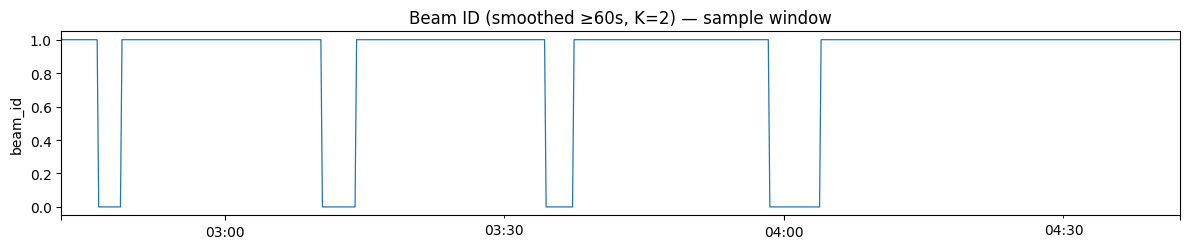

In [6]:
# Step 6 - BEAM-ID INFERENCE (PCA + MiniBatchKMeans) WITH FAST K SELECTION
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Building a compact beam-state representation from modem vectors (beam_vec)
#   - Avoiding leakage: fit scaler + PCA on TRAIN only
#   - Choosing K via silhouette on a ~20k TRAIN subsample
#   - Fitting MiniBatchKMeans on full TRAIN; predict beam_id for ALL rows
#   - Smoothing short flickers (≥60s) to get stable beam_id
#   - Persist artifacts (scaler, pca, kmeans, beam_id, Z_* and K choice)
# Inputs expected:
#   - beam_vec : DataFrame (index=time)
#   - ART_DIR  : base folder
#   - If split1/split2 are not defined yet, creates provisional 60/20/20 splits by index
# -------------------------------------------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import joblib

# ---- Guards & provisional splits ----
assert 'beam_vec' in globals() and isinstance(beam_vec, pd.DataFrame), "beam_vec DataFrame missing."

# Create provisional time-ordered 60/20/20 splits if not provided yet
if 'split1' not in globals() or 'split2' not in globals():
    n_idx = len(beam_vec)
    split1 = int(n_idx * 0.60)  # TRAIN end
    split2 = int(n_idx * 0.80)  # VAL end / TEST start
    print(f"[Step6] Provisional splits created → split1={split1}, split2={split2} (60/20/20 by index)")

idx = beam_vec.index
n, d = beam_vec.shape
print(f"[Step6] beam_vec shape: {beam_vec.shape}  range: {idx.min()} → {idx.max()}")

# Artifacts folder
BASE_DIR = ART_DIR if 'ART_DIR' in globals() else "."
OUT = os.path.join(BASE_DIR, "artifacts_beam")
os.makedirs(OUT, exist_ok=True)

# ---- Train/All matrices (float32 for speed) ----
X_all = beam_vec.copy()

# ensure numeric
for c in X_all.columns:
    if X_all[c].dtype == 'object':
        X_all[c] = pd.to_numeric(X_all[c], errors='coerce')

# forward/backward fill (replaces deprecated fillna(method=...))
X_all = X_all.ffill().bfill().astype(np.float32)

# partition by index position (time-ordered)
X_train = X_all.iloc[:split1].copy()
print(f"[Step6] TRAIN rows: {len(X_train)} | ALL rows: {len(X_all)}")

# ---- Scale (TRAIN-only fit) ----
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_s = scaler.fit_transform(X_train.values)      # fit on TRAIN
X_all_s   = scaler.transform(X_all.values)            # transform ALL

# ---- PCA (TRAIN-only fit) ----
pca_k = min(6, X_all_s.shape[1])   # small, robust latent space
pca = PCA(n_components=pca_k, svd_solver='auto', random_state=42)
Z_train = pca.fit_transform(X_train_s).astype(np.float32)
Z_all   = pca.transform(X_all_s).astype(np.float32)

expl = float(pca.explained_variance_ratio_.sum())
print(f"[Step6] PCA dims: {pca_k} | variance explained: {expl:.3f}")

# ---- K selection: silhouette on TRAIN subsample ----
if len(Z_train) < 10:
    raise RuntimeError("[Step6] Not enough TRAIN rows for clustering. Check earlier steps.")

SAMPLE_N = min(20000, len(Z_train))
rng = np.random.RandomState(42)
perm = rng.choice(len(Z_train), SAMPLE_N, replace=False)
Z_sub = Z_train[perm]

best = {"k": None, "score": -1.0, "model": None}
for k in range(2, 7):  # try K = 2..6
    try:
        km = MiniBatchKMeans(
            n_clusters=k, batch_size=2048, n_init=5,
            max_iter=200, random_state=42, verbose=0
        )
        km.fit(Z_train)                       # fit on full TRAIN
        labs_sub = km.predict(Z_sub)
        sc = float(silhouette_score(Z_sub, labs_sub, metric="euclidean"))
        print(f"[Step6] K={k}: silhouette@{SAMPLE_N}={sc:.3f}")
        if sc > best["score"]:
            best = {"k": k, "score": sc, "model": km}
    except Exception as e:
        print(f"[Step6] K={k} silhouette failed: {e}")

# Fallback if nothing succeeded
if best["model"] is None:
    print("[Step6][WARN] Silhouette selection failed; falling back to K=2.")
    best["k"] = 2
    best["model"] = MiniBatchKMeans(
        n_clusters=2, batch_size=2048, n_init=5,
        max_iter=200, random_state=42, verbose=0
    ).fit(Z_train)
    best["score"] = -1.0

kmeans = best["model"]
print(f"[Step6] Chosen K={best['k']} (silhouette={best['score']:.3f})")

# ---- Predict clusters for all timestamps ----
beam_id_raw = kmeans.predict(Z_all)
beam_id_raw = pd.Series(beam_id_raw, index=idx, name="beam_id_raw")

# ---- Smooth flickers: collapse runs shorter than 60s to previous state ----
CADENCE_S = 10
min_len_steps = max(1, int(60 / CADENCE_S))  # 60s at 10s cadence = 6 steps

def smooth_states(s: pd.Series, min_len_steps: int = 6) -> pd.Series:
    x = s.values.copy()
    start = 0
    for i in range(1, len(x) + 1):
        if i == len(x) or x[i] != x[start]:
            run_len = i - start
            if run_len < min_len_steps and start > 0:
                x[start:i] = x[start - 1]
            start = i
    return pd.Series(x, index=s.index, name="beam_id")

beam_id = smooth_states(beam_id_raw, min_len_steps=min_len_steps)

# ---- Quick telemetry ----
n_switches = int((beam_id.shift(1) != beam_id).fillna(False).sum())
print(f"[Step6] Unique beams: {beam_id.nunique()} | switches: {n_switches} "
      f"| first 5 states: {beam_id.head().tolist()}")

# ---- Persist artifacts ----
joblib.dump(scaler, os.path.join(OUT, "beam_scaler.joblib"))
joblib.dump(pca,    os.path.join(OUT, "beam_pca.joblib"))
joblib.dump(kmeans, os.path.join(OUT, "beam_kmeans.joblib"))
beam_id.to_csv(os.path.join(OUT, "beam_id_series.csv"))
np.save(os.path.join(OUT, "Z_train.npy"), Z_train)
np.save(os.path.join(OUT, "Z_all.npy"),   Z_all)
with open(os.path.join(OUT, "k_choice.txt"), "w") as f:
    f.write(f"K={best['k']}, silhouette@{SAMPLE_N}={best['score']:.4f}\n")

print("Saved:", os.path.join(OUT, "beam_scaler.joblib"))
print("Saved:", os.path.join(OUT, "beam_pca.joblib"))
print("Saved:", os.path.join(OUT, "beam_kmeans.joblib"))
print("Saved:", os.path.join(OUT, "beam_id_series.csv"))

# ---- (Optional) small diagnostic plot over a ~2h window (centered) ----

mid = len(idx) // 2
half = 720 // 2
start = max(0, mid - half)
end = min(len(idx) - 1, mid + half)

try:
    #mid = len(idx) // 2
    #start = max(0, mid)
    #end = min(len(idx) - 1, mid + 720)  # ~2h at 10s cadence
    #--
    mid = len(idx) // 2
    half = 720 // 2
    start = max(0, mid - half)
    end = min(len(idx) - 1, mid + half)
    #--
    win = slice(idx[start], idx[end])
    fig, ax = plt.subplots(figsize=(12, 2.6))
    beam_id.loc[win].plot(ax=ax, lw=0.9)
    ax.set_title(f"Beam ID (smoothed ≥60s, K={best['k']}) — sample window")
    ax.set_ylabel("beam_id"); ax.set_xlabel("")
    plt.tight_layout()
    fig_path = os.path.join(OUT, "beam_id_sample.png")
    plt.savefig(fig_path, dpi=120)
    print("Saved:", fig_path)
except Exception as e:
    print("[Step6] Plot skipped:", e)

# Expose for downstream steps
BEAM_PCA_DIM = pca_k
BEAM_K       = best['k']


In [7]:
# Step 7 - HANDOVER CANDIDATES + TRAINED THRESHOLDS + LABELS (DILATION PERSISTENCE)
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Detect handovers from inferred beam_id (Step 6)
#   - Compute per-handover features:
#       * drop_pct  : pre→post throughput % drop
#       * since_prev: seconds since previous handover (ping-pong proxy)
#       * recovery_s: time until throughput returns within 90% of pre (capped)
#   - Learn anomaly thresholds from TRAIN only (robust percentiles with sensible fallbacks)
#   - Label anomalous handovers (instantaneous), then DILATE for PERSIST_S seconds
#   - Build early-warning labels by shifting forward (lead) in time
#   - Persist HOV table and learned thresholds
# -------------------------------------------------------------------------------------------------

import numpy as np
import pandas as pd
import json
import os

# ---- Guards & basics ----
assert 'res' in globals() and isinstance(res, pd.DataFrame), "Step 7 needs 'res' (Step 4 output)."
assert 'thr_name' in globals(), "Step 7 needs 'thr_name' (throughput proxy col)."
assert 'beam_id' in globals(), "Step 7 needs 'beam_id' (from Step 6)."
assert 'ART_DIR' in globals(), "Step 7 needs 'ART_DIR' to save artifacts."

CADENCE_S = 10  # we resampled to 10s in Step 4

# If Step 6 didn't export idx_train/idx_test, rebuild from split1/split2
if 'idx_train' not in globals() or 'idx_test' not in globals():
    assert 'split1' in globals() and 'split2' in globals(), "Need split1/split2 (from Step 6) to derive TRAIN/TEST windows."
    idx_all   = res.index
    idx_train = idx_all[:split1]
    idx_test  = idx_all[split2:]

# ---- Throughput series (light smoothing to reduce glitches) ----
thr = res[thr_name].copy()
thr = thr.rolling(3, min_periods=1).median()

# ---- Detect handover candidates (change in smoothed beam state from Step 6) ----
chg = (beam_id != beam_id.shift(1)).fillna(False).astype(int)
handover_ts = beam_id.index[chg.values == 1]

# ---- Helpers for per-handover features ----
def pre_post_means(ts, pre_s=120, post_s=180):
    """Mean throughput in pre/post windows around ts."""
    pre_n  = max(1, pre_s // CADENCE_S)
    post_n = max(1, post_s // CADENCE_S)
    loc = thr.index.get_indexer([ts])[0]
    pre  = thr.iloc[max(0, loc - pre_n):loc].mean()
    post = thr.iloc[loc:min(len(thr), loc + post_n)].mean()
    return pre, post

def recovery_time(ts, pre_value, tol=0.90, cap_s=1800):
    """Seconds until throughput >= tol * pre_value (capped)."""
    target = pre_value * tol
    loc = thr.index.get_indexer([ts])[0]
    for j in range(loc, min(len(thr), loc + cap_s // CADENCE_S)):
        if thr.iloc[j] >= target:
            return (thr.index[j] - ts).total_seconds()
    return float(cap_s)

def pct(s, p):
    s = pd.Series(s).dropna()
    return float(np.nanpercentile(s, p)) if len(s) else np.nan

# ---- Build per-handover feature table (HOV) ----
records = []
for t in handover_ts:
    pre, post = pre_post_means(t, pre_s=120, post_s=180)
    drop_pct = 0.0 if pre <= 0 else (pre - post) / pre
    records.append({"t": t, "pre": float(pre), "post": float(post), "drop_pct": float(drop_pct)})

HOV = pd.DataFrame.from_records(records).set_index("t").sort_index()
if not HOV.empty:
    # r2 proxy: seconds since previous handover
    HOV["since_prev_s"] = HOV.index.to_series().diff().dt.total_seconds().fillna(np.inf)
    # r3: recovery seconds back to 90% of pre (cap 30 min)
    HOV["recovery_s"] = [recovery_time(t, row["pre"], tol=0.90, cap_s=1800) for t, row in HOV.iterrows()]
else:
    HOV["since_prev_s"] = pd.Series(dtype=float)
    HOV["recovery_s"]   = pd.Series(dtype=float)

# ---- Learn anomaly thresholds from TRAIN only (robust & relaxed fallbacks) ----
HOV_train = HOV.loc[(HOV.index >= idx_train[0]) & (HOV.index <= idx_train[-1])]

# R1: post-handover drop threshold (use p90, but not below a minimum like 1%)
drop_thr = pct(HOV_train["drop_pct"], 90)
if np.isnan(drop_thr) or drop_thr < 0.01:
    drop_thr = 0.01  # 1% minimum sensitivity

# R2: ping-pong threshold (seconds). Use max(5 min, p40 of TRAIN spacing) to be more permissive.
ping_thr = max(300.0, pct(HOV_train["since_prev_s"], 40))
if np.isnan(ping_thr) or ping_thr < 300.0:
    ping_thr = 300.0

# R3: slow recovery threshold (seconds). Use p90 with a floor (≥45s) to catch long recoveries.
rec_thr = pct(HOV_train["recovery_s"], 90)
if np.isnan(rec_thr) or rec_thr < 45.0:
    rec_thr = 45.0

THR = {"drop_pct_thr": float(drop_thr), "pingpong_s": float(ping_thr), "recovery_s_thr": float(rec_thr)}
print("Learned (TRAIN) anomaly thresholds:", THR)

# ---- Apply rules to ALL handovers ----
#HOV["r1_drop"] = (HOV["drop_pct"] > THR["drop_pct_thr"]).astype(int)
#HOV["r2_ping"] = (HOV["since_prev_s"] < THR["pingpong_s"]).astype(int)
#HOV["r3_slow"] = (HOV["recovery_s"] > THR["recovery_s_thr"]).astype(int)
#HOV["anomalous"] = ((HOV["r1_drop"] | HOV["r2_ping"] | HOV["r3_slow"]) > 0).astype(int)

# Label anomalies for ALL handovers
HOV["r1_drop"] = (HOV["drop_pct"] > THR["drop_pct_thr"]).astype(int)

# HYBRID r2
window_s = min(float(THR["pingpong_s"]), 240.0)
mild_drop_thr = max(0.01, 0.25 * float(THR["drop_pct_thr"]))
pp_quick   = (HOV["since_prev_s"] < window_s)
pp_quality = (HOV["drop_pct"] > mild_drop_thr)
HOV["r2_ping"] = (pp_quick & pp_quality).astype(int)

HOV["r3_slow"]   = (HOV["recovery_s"] > THR["recovery_s_thr"]).astype(int)
HOV["anomalous"] = ((HOV["r1_drop"] | HOV["r2_ping"] | HOV["r3_slow"]) > 0).astype(int)


# Optional diagnostics: rule hit counts
if not HOV.empty:
    print("[Rule hits across ALL handovers] r1/r2/r3:", {
        "r1": int(HOV["r1_drop"].sum()),
        "r2": int(HOV["r2_ping"].sum()),
        "r3": int(HOV["r3_slow"].sum()),
        "any": int(HOV["anomalous"].sum())
    })

# ---- Label construction (dilation persistence) ----
# Starting with sparse 1's at anomalous handover instants
y_sparse = pd.Series(0, index=res.index, name="handover_anom_now")
if not HOV.empty:
    anom_ts = HOV.index[HOV["anomalous"] == 1]
    y_sparse.loc[anom_ts] = 1
y_sparse = y_sparse.astype(int)

# DILATE forward for PERSIST_S seconds so single-tick events become short windows (no "run==persist_steps" wipeout)
PERSIST_S = 30  # keep modest to avoid over-widening
persist_steps = max(1, int(PERSIST_S // CADENCE_S))

if y_sparse.sum() > 0 and persist_steps > 1:
    arr = y_sparse.values.copy()
    n = len(arr)
    ones_idx = np.flatnonzero(arr == 1)
    for i in ones_idx:
        j = min(n, i + persist_steps)   # paint [i, j) as 1
        arr[i:j] = 1
    y_now = pd.Series(arr, index=y_sparse.index, name="handover_anom_now").astype(int)
else:
    y_now = y_sparse.copy()

# Early warning target: shift forward by EARLY_WARNING_MIN minutes
EARLY_WARNING_MIN = 2
lead_steps = max(1, int((EARLY_WARNING_MIN * 60) // CADENCE_S))
y_lead = y_now.shift(-lead_steps).fillna(0).astype(int)

# ---- Telemetry ----
total_handovers   = int((beam_id != beam_id.shift(1)).fillna(False).sum())
total_anom_events = int(HOV["anomalous"].sum()) if not HOV.empty else 0
print(f"Label prevalence (now/lead): {y_now.mean():.4f} {y_lead.mean():.4f}")
print(f"[Labels] handovers={total_handovers} | anomalous={total_anom_events} "
      f"| after dilation sum(y_now)={int(y_now.sum())} lead sum(y_lead)={int(y_lead.sum())}")

# Daily counts for sanity (lead labels)
y_lead_daily = y_lead.groupby(pd.Grouper(freq="1D")).sum().rename("y_lead")
print("[Labels] Positives per day (lead):")
print(y_lead_daily.loc[y_lead_daily.index.min():y_lead_daily.index.max()].fillna(0).astype(int).tail(14))

# ---- Persist artifacts ----
HOV_path = os.path.join(ART_DIR, "handover_table.csv")
THR_path = os.path.join(ART_DIR, "handover_thresholds.json")
HOV.to_csv(HOV_path)
with open(THR_path, "w") as f:
    json.dump(THR, f, indent=2)
print("Saved:", HOV_path)
print("Saved:", THR_path)



Learned (TRAIN) anomaly thresholds: {'drop_pct_thr': 0.041967432986525284, 'pingpong_s': 300.0, 'recovery_s_thr': 45.0}
[Rule hits across ALL handovers] r1/r2/r3: {'r1': 427, 'r2': 1043, 'r3': 4, 'any': 1214}
Label prevalence (now/lead): 0.0096 0.0096
[Labels] handovers=5271 | anomalous=1214 | after dilation sum(y_now)=3642 lead sum(y_lead)=3639
[Labels] Positives per day (lead):
_time
2021-11-17 00:00:00+00:00    86
2021-11-18 00:00:00+00:00    40
2021-11-19 00:00:00+00:00     0
2021-11-20 00:00:00+00:00     0
2021-11-21 00:00:00+00:00     9
2021-11-22 00:00:00+00:00    24
2021-11-23 00:00:00+00:00     6
2021-11-24 00:00:00+00:00     9
2021-11-25 00:00:00+00:00    27
2021-11-26 00:00:00+00:00    36
2021-11-27 00:00:00+00:00    27
2021-11-28 00:00:00+00:00    36
2021-11-29 00:00:00+00:00    42
2021-11-30 00:00:00+00:00    51
Freq: D, Name: y_lead, dtype: int64
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/handover_table.csv
Saved: /content/drive/

In [8]:
# Step 8 - FEATURES (enhanced) + LABEL-AWARE SPLITS + SCALING
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Build stronger features for handover anomaly prediction
#   - Ensuring TRAIN/VAL both have positives via label-aware split search
#   - Scaling using TRAIN-only; expose standardized names for Step 9

from sklearn.preprocessing import RobustScaler
import numpy as np, pandas as pd, joblib, os

assert 'res' in globals() and isinstance(res, pd.DataFrame), "Step 4+ dataframe `res` missing."
assert 'thr_name' in globals(), "Throughput proxy name `thr_name` missing."
assert 'beam_id' in globals(), "`beam_id` (from Step 6) missing."
assert 'y_lead' in globals() or 'y_now' in globals(), "Labels from Step 7 missing."

CADENCE_S = 10
USE_LOOKAHEAD_FEATURES = True   # set False for production/strictly causal features

def make_features(df: pd.DataFrame, beam_id_series: pd.Series, thr_col: str,
                  use_lookahead: bool = True) -> pd.DataFrame:
    """Feature recipe for handover anomalies (timeline)."""
    X = pd.DataFrame(index=df.index)
    s = df[thr_col].astype(float)

    # --- Rolling stats (10s cadence: 3≈30s, 12≈2m)
    X["thr"]           = s
    X["thr_mean_30s"]  = s.rolling(3,  min_periods=1).mean()
    X["thr_std_30s"]   = s.rolling(3,  min_periods=1).std()
    X["thr_mean_2m"]   = s.rolling(12, min_periods=1).mean()
    X["thr_std_2m"]    = s.rolling(12, min_periods=1).std()
    X["thr_slope_50s"] = s.diff().rolling(5, min_periods=1).mean()

    # --- Beam dynamics
    bid = beam_id_series.reindex(X.index).ffill().bfill()
    X["beam_id"] = bid
    change = (bid != bid.shift(1)).astype(int)
    X["beam_change_1"] = change

    # Dwell (since last change)
    steps_since = []
    last = None
    for i, val in enumerate(bid):
        if i == 0:
            steps_since.append(0); last = val; continue
        if val != last:
            steps_since.append(0); last = val
        else:
            steps_since.append(steps_since[-1] + 1)
    X["beam_steps_since_change"] = steps_since

    # Recent change rate
    X["chg_5m"]  = change.rolling(30,  min_periods=1).sum()
    X["chg_10m"] = change.rolling(60,  min_periods=1).sum()

    # --- Pre/Post deltas (research-time; for production set use_lookahead=False)
    X["thr_pre_2m"] = s.rolling(12, min_periods=1).mean()
    if use_lookahead:
        X["thr_post_2m"] = s.shift(-12).rolling(12, min_periods=1).mean()
        X["thr_delta"]   = X["thr_post_2m"] - X["thr_pre_2m"]
        X["thr_drop_pct"]= (X["thr_pre_2m"] - X["thr_post_2m"]) / X["thr_pre_2m"].replace(0, np.nan)
    else:
        # causal placeholder (EMA as proxy)
        X["thr_post_2m"] = X["thr_mean_2m"]
        X["thr_delta"]   = X["thr_mean_2m"] - X["thr_pre_2m"]
        X["thr_drop_pct"]= (X["thr_pre_2m"] - X["thr_mean_2m"]) / X["thr_pre_2m"].replace(0, np.nan)

    # Optional context
    if "in_maneuver" in df.columns:
        X["in_maneuver"] = df["in_maneuver"].astype(int)

    # Clean up
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return X

# ---- Build features
X = make_features(res, beam_id, thr_name, use_lookahead=USE_LOOKAHEAD_FEATURES)

# ---- Align labels
y_all = (y_lead if 'y_lead' in globals() else y_now).reindex(X.index).fillna(0).astype(int)

# ---- Label-aware split search (ensure TRAIN and VAL have positives)
def find_splits(y, min_pos_train=3, min_pos_val=3,
                test_fracs=(0.20, 0.18, 0.15, 0.12, 0.10),
                train_fracs=(0.60, 0.55, 0.50, 0.45),
                val_fracs=(0.20, 0.25, 0.30)):
    n = len(y)
    def count_pos(s1, s2):
        return int(y.iloc[:s1].sum()), int(y.iloc[s1:s2].sum()), int(y.iloc[s2:].sum())

    best = None
    # Try classic 60/20/20 style first
    for tf in test_fracs:
        s2 = int(n * (1 - tf))
        for trf in train_fracs:
            s1 = int(n * trf)
            if s1 >= s2 or s1 < int(n * 0.30):  # guard
                continue
            tr, va, te = count_pos(s1, s2)
            if tr >= min_pos_train and va >= min_pos_val:
                best = (s1, s2, tr, va, te); break
        if best: break

    # If not found, fix TEST and vary VAL ahead of TEST
    if best is None:
        for tf in test_fracs:
            s2 = int(n * (1 - tf))
            for vaf in val_fracs:
                s1 = int(s2 - n * vaf)
                if s1 <= 0 or s1 >= s2:
                    continue
                tr, va, te = count_pos(s1, s2)
                if tr >= min_pos_train and va >= min_pos_val:
                    best = (s1, s2, tr, va, te); break
            if best: break
    return best

res_split = find_splits(y_all, min_pos_train=3, min_pos_val=3)
if res_split is None:
    raise ValueError(
        "[Step8] Could not find label-aware splits with positives in TRAIN and VAL. "
        "Relax label creation (lower PERSIST_S / thresholds) or shrink TEST slightly."
    )

split1, split2, tr_pos, va_pos, te_pos = res_split
n_total = len(X)
print(f"[Step8] n={n_total} | split1={split1} (TRAIN end), split2={split2} (VAL end / TEST start)")
print(f"[Step8] Positives -> TRAIN={tr_pos} | VAL={va_pos} | TEST={te_pos}")

# ---- Build splits (time-ordered)
X_train, y_train = X.iloc[:split1], y_all.iloc[:split1]
X_val,   y_val   = X.iloc[split1:split2], y_all.iloc[split1:split2]
X_test,  y_test  = X.iloc[split2:],       y_all.iloc[split2:]

print(f"[Step8] Shapes -> TRAIN={X_train.shape}, VAL={X_val.shape}, TEST={X_test.shape}")
print(f"[Step8] Label means (pos rate) -> TRAIN={y_train.mean():.4f} | VAL={y_val.mean():.4f} | TEST={y_test.mean():.4f}")

# ---- Scale (TRAIN only)
feat_scaler = RobustScaler()
#feat_scaler = RobustScaler()
#X_train_s = pd.DataFrame(feat_scaler.fit_transform(X_train), ...)
# …and persist feat_scaler instead of scaler

#scaler = RobustScaler()
X_train_s = pd.DataFrame(feat_scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_val_s   = pd.DataFrame(feat_scaler.transform(X_val),       index=X_val.index,   columns=X_val.columns)
X_test_s  = pd.DataFrame(feat_scaler.transform(X_test),      index=X_test.index,  columns=X_test.columns)

# ---- Expose standardized names for Step 9
X_train, X_val, X_test = X_train_s, X_val_s, X_test_s

# (Optional) persist scaler for reproducibility
try:
    base_dir = ART_DIR if 'ART_DIR' in globals() else "."
    os.makedirs(base_dir, exist_ok=True)
    scaler_path = os.path.join(base_dir, "scaler_step8.joblib")
    joblib.dump(scaler, scaler_path)
    print("Saved scaler:", scaler_path)
except Exception as e:
    print("Scaler save skipped:", e)


[Step8] n=377489 | split1=226493 (TRAIN end), split2=301991 (VAL end / TEST start)
[Step8] Positives -> TRAIN=2925 | VAL=462 | TEST=252
[Step8] Shapes -> TRAIN=(226493, 16), VAL=(75498, 16), TEST=(75498, 16)
[Step8] Label means (pos rate) -> TRAIN=0.0129 | VAL=0.0061 | TEST=0.0033
Saved scaler: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/scaler_step8.joblib


In [9]:
# Step 9 - TRAIN MODEL (XGB, robust + early stopping via xgboost.train)
# -------------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import average_precision_score, roc_auc_score

# --- Clean matrices (no NaN/Inf, float32)
def _clean(df):
    return df.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(np.float32)

X_train = _clean(X_train)
X_val   = _clean(X_val)
X_test  = _clean(X_test)

y_train = y_train.astype(int)
y_val   = y_val.astype(int)
y_test  = y_test.astype(int)

print(f"[Step9] Shapes — TRAIN: {X_train.shape} (pos={int(y_train.sum())}), "
      f"VAL: {X_val.shape} (pos={int(y_val.sum())}), "
      f"TEST: {X_test.shape} (pos={int(y_test.sum())})")

# --- Imbalance setup
prev = float(y_train.mean())
base_score_safe    = float(np.clip(prev, 1e-6, 1 - 1e-6))
scale_pos_weight   = float((len(y_train) - y_train.sum()) / max(1, y_train.sum()))
print(f"[Step9] Imbalance setup -> prevalence={prev:.5f}, base_score={base_score_safe:.6f}, "
      f"scale_pos_weight={scale_pos_weight:.2f}")

# --- DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train.values)
dval   = xgb.DMatrix(X_val,   label=y_val.values)
dtest  = xgb.DMatrix(X_test)

# --- Params (binary logistic, PR-AUC early stop on VAL)
params = {
    "objective": "binary:logistic",
    "tree_method": "hist",
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "scale_pos_weight": scale_pos_weight,
    "base_score": base_score_safe,
    "eval_metric": "aucpr",
    "seed": 42,
}

# --- Train with early stopping
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,                 # upper cap; early stopping will prune
    evals=[(dtrain, "train"), (dval, "validation")],
    early_stopping_rounds=100,
    verbose_eval=False
)

best_iter = getattr(booster, "best_iteration", None)
if best_iter is not None:
    print(f"[Step9] Early stopping best_iteration: {best_iter}")

# --- Probabilities using best iteration
if hasattr(booster, "best_iteration") and booster.best_iteration is not None:
    it_range = (0, booster.best_iteration + 1)
    proba_val  = booster.predict(dval,  iteration_range=it_range)
    proba_test = booster.predict(dtest, iteration_range=it_range)
else:
    proba_val  = booster.predict(dval)
    proba_test = booster.predict(dtest)

# --- Metrics
def _safe_metric(fn, y, p, name):
    try:
        v = fn(y, p)
        print(f"{name}: {v:.4f}")
        return float(v)
    except Exception as e:
        print(f"[Step9] {name} unavailable:", e)
        return float("nan")

ap_val = _safe_metric(average_precision_score, y_val,  proba_val,  "VAL — PR-AUC")
ap_te  = _safe_metric(average_precision_score, y_test, proba_test, "TEST — PR-AUC")
roc_te = _safe_metric(roc_auc_score,          y_test, proba_test, "TEST — ROC-AUC")

# Expose names used downstream
ap_va   = ap_val
clf     = booster            # keep a 'clf' handle; booster has .save_model(...)
test_index = X_test.index    # Step 11 expects test_index
print("[Step9] Done. Variables ready -> clf(booster), proba_val, proba_test, ap_val/ap_va, test_index")


[Step9] Shapes — TRAIN: (226493, 16) (pos=2925), VAL: (75498, 16) (pos=462), TEST: (75498, 16) (pos=252)
[Step9] Imbalance setup -> prevalence=0.01291, base_score=0.012914, scale_pos_weight=76.43
[Step9] Early stopping best_iteration: 226
VAL — PR-AUC: 0.1051
TEST — PR-AUC: 0.0222
TEST — ROC-AUC: 0.7065
[Step9] Done. Variables ready -> clf(booster), proba_val, proba_test, ap_val/ap_va, test_index


In [10]:
## Step 10 - THRESHOLD SELECTION — unified tiered policy
# -----------------------------------------------
# Tier 1: precision-first with caps (prefer F0.5, then higher t)
# Tier 2: alerts/day policy with precision floor and rate caps
# Tier 3: quantile fallback (VAL q99.5)
#
# Outputs:
#   thr_star        (float)   final decision threshold
#   TAU_PICKED_BY   (str)     one of {"precision-first","alerts/day","quantile"}
#
from sklearn.metrics import precision_recall_curve
import numpy as np
import pandas as pd
import json, os

# --- Config knobs
TARGET_PRECISION     = 0.85
RELAXED_PRECS        = [0.70, 0.60]     # try in order if 0.85 fails
MAX_POS_RATE_VAL     = 0.010            # ≤1.0% of VAL predicted positive
MIN_VAL_POS          = 10               # at least this many positives on VAL
FBETA                = 0.5              # precision-weighted
ALERTS_PER_DAY_RANGE = (3, 15)          # Tier-2 target range
PREC_FLOOR_ALERTS    = 0.60             # minimum precision in Tier-2
MAX_POS_PCT_VAL      = 1.50             # ≤1.5% positives on VAL
RELAXED_ALERTS       = (2, 20)          # emergency relaxed APD window
RELAXED_PREC_ALERTS  = 0.50             # emergency relaxed precision floor
QUANT_FALLBACK_Q     = 0.995            # Tier-3 quantile

# --- Curves
prec, rec, thr = precision_recall_curve(y_val, proba_val)
thr = np.r_[thr, 1.0]  # align to same length as prec/rec

df = pd.DataFrame({"tau": thr, "precision": prec, "recall": rec}).sort_values("tau")

def pos_counts(prob, taus):
    p = np.asarray(prob)
    return np.array([(p >= t).sum() for t in taus], dtype=int)

df["val_pos"]  = pos_counts(proba_val,  df["tau"].values)
df["val_rate"] = df["val_pos"] / len(proba_val)

beta2 = FBETA**2
df["Fbeta"] = (1 + beta2) * (df["precision"] * df["recall"]) / np.clip(beta2 * df["precision"] + df["recall"], 1e-12, None)

# --- Helpers for Tier-2
VAL_INDEX = X_val.index
val_days = max( (VAL_INDEX[-1] - VAL_INDEX[0]).total_seconds() / 86400.0, 1e-6 )

def alerts_per_day_at_tau(tau):
    sig = (proba_val >= tau).astype(int)
    rises = np.diff(np.r_[0, sig, 0])
    events = (rises == 1).sum()
    return events / val_days

def positives_pct_at_tau(tau):
    return 100.0 * (proba_val >= tau).mean()

# ------------------
# Tier 1: Precision-first
# ------------------
def pick_with_floor(floor):
    cand = df[
        (df["precision"] >= floor) &
        (df["val_rate"] <= MAX_POS_RATE_VAL) &
        (df["val_pos"]  >= MIN_VAL_POS)
    ]
    if len(cand):
        return cand.sort_values(["Fbeta","tau"], ascending=[False, False]).iloc[0]
    return None

row = pick_with_floor(TARGET_PRECISION)
TAU_PICKED_BY = None

if row is None:
    for f in RELAXED_PRECS:
        r = pick_with_floor(f)
        if r is not None:
            row = r
            break

if row is not None:
    thr_star = float(row["tau"])
    TAU_PICKED_BY = "precision-first"
else:
    # ------------------
    # Tier 2: Alerts/day policy (bounded)
    # ------------------
    cands = []
    for p, r, t in zip(df["precision"], df["recall"], df["tau"]):
        apd = alerts_per_day_at_tau(t)
        pos_pct = positives_pct_at_tau(t)
        if (p >= PREC_FLOOR_ALERTS) and (ALERTS_PER_DAY_RANGE[0] <= apd <= ALERTS_PER_DAY_RANGE[1]) and (pos_pct <= MAX_POS_PCT_VAL):
            cands.append((t, p, r, apd, pos_pct))
    if not cands:
        # relaxed emergency mode
        for p, r, t in zip(df["precision"], df["recall"], df["tau"]):
            apd = alerts_per_day_at_tau(t)
            pos_pct = positives_pct_at_tau(t)
            if (p >= RELAXED_PREC_ALERTS) and (RELAXED_ALERTS[0] <= apd <= RELAXED_ALERTS[1]) and (pos_pct <= (MAX_POS_PCT_VAL*1.3)):
                cands.append((t, p, r, apd, pos_pct))

    if cands:
        def fbeta(p, r, b=FBETA):
            b2 = b*b
            return (1+b2)*p*r / (b2*p + r + 1e-9)
        best = max(cands, key=lambda x: (fbeta(x[1], x[2], FBETA), x[1], x[2]))
        thr_star = float(best[0])
        TAU_PICKED_BY = "alerts/day"
    else:
        # ------------------
        # Tier 3: Quantile fallback
        # ------------------
        thr_star = float(np.quantile(proba_val, QUANT_FALLBACK_Q))
        TAU_PICKED_BY = "quantile"

print(f"[Step10] Validation AP: {float(ap_va):.4f}")
print(f"[Step10] Final t = {thr_star:.3f} | picked by: {TAU_PICKED_BY}")

# Persist tau meta (optional; used later by Step 15 wording)
with open(os.path.join(ART_DIR, "tau_meta.json"), "w") as f:
    json.dump({"tau": float(thr_star), "picked_by": TAU_PICKED_BY}, f, indent=2)


[Step10] Validation AP: 0.1051
[Step10] Final t = 0.946 | picked by: quantile


In [11]:

# Step 11 - EVENTIZATION (EMA + hysteresis + debounce) — Guardrailed Tier-2 Search
# ---------------------------------------------------------------------------
# Purpose:
#   1) Building a Tier-2 grid around τ (thr_star) and proba quantiles
#   2) Evaluating candidates (FAR, Precision/Recall, Delay, Alerts)
#   3) Applying GUARDRAIL policy (Precision floor + FAR cap + debounce floor)
#   4) Locking ONLY the guardrail winner to eventization_winner.json
#   5) Print near-miss diagnostics (midpoint distance & brief coverage)
#
# Inputs required from earlier steps:
#   - thr_star (Step 10), proba_test & test_index (Step 9), y_test (Step 8)
#   - ART_DIR (Step 1/3/4 etc.)
#
# ---------------------------------------------------------------------------

import numpy as np, pandas as pd, json, os
import matplotlib.pyplot as plt

# ----- Helpers -----
def hysteresis(prob: pd.Series, on_thr: float, off_thr: float) -> pd.Series:
    on = (prob >= on_thr).values
    off = (prob <= off_thr).values
    out, state = np.zeros(len(prob), dtype=np.int8), 0
    for i in range(len(prob)):
        if state == 0 and on[i]: state = 1
        elif state == 1 and off[i]: state = 0
        out[i] = state
    return pd.Series(out, index=prob.index, dtype=int)

def n_of_m(binary_like: pd.Series, k: int, m: int) -> pd.Series:
    return (binary_like.rolling(m, min_periods=1).sum() >= k).astype(int)

def series_to_events(sig01: pd.Series):
    x = sig01.values.astype(int); idx = sig01.index
    d = np.diff(np.r_[0, x, 0]); starts = np.where(d==1)[0]; ends = np.where(d==-1)[0]
    return [(idx[s], idx[e-1]) for s, e in zip(starts, ends)]

def prune_and_merge(events, min_duration_s, refractory_s):
    kept = []
    for s, e in events:
        if (e - s).total_seconds() + 1e-9 >= min_duration_s:
            kept.append([s, e])
    if not kept: return []
    out = [kept[0]]
    for s, e in kept[1:]:
        ps, pe = out[-1]
        if (s - pe).total_seconds() <= refractory_s:
            out[-1][1] = max(pe, e)
        else:
            out.append([s, e])
    return [(s, e) for s, e in out]

def alerts_per_hour(events, total_seconds):
    return len(events) / max(1e-6, total_seconds/3600.0)

def detection_delays_median(true_events, pred_events):
    ps = np.array([s.value for s,_ in pred_events], dtype=np.int64)
    delays = []
    for ts,_ in true_events:
        t = ts.value
        i = np.searchsorted(ps, t, side='left')
        if i < len(ps):
            delays.append((ps[i]-t)/1e9)
    return float(np.median(delays)) if delays else np.nan

def event_overlap_precision_recall(true_events, pred_events, iou_thresh=0.10):
    def iou(a,b):
        s1,e1=a; s2,e2=b
        inter=max(0.0,(min(e1,e2)-max(s1,s2)).total_seconds())
        uni=(e1-s1).total_seconds()+(e2-s2).total_seconds()-inter
        return (inter/uni) if uni>0 else 0.0
    matched=set(); tp=0
    for gt in true_events:
        best=-1; bj=-1
        for j,pe in enumerate(pred_events):
            if j in matched: continue
            val=iou(gt,pe)
            if val>best: best, bj = val, j
        if best>=iou_thresh and bj>=0:
            tp+=1; matched.add(bj)
    fp=len(pred_events)-len(matched)
    fn=len(true_events)-tp
    P = tp/(tp+fp) if (tp+fp) else np.nan
    R = tp/(tp+fn) if (tp+fn) else np.nan
    return P, R

def event_midpoints(evts):
    return np.array([s.value + 0.5*(e.value - s.value) for s,e in evts], dtype=np.float64)

# ----- Inputs + anchors from τ -----
assert 'proba_test' in globals() and 'test_index' in globals(), "[Step11] Missing proba_test/test_index (Step 9)."
assert 'y_test' in globals(), "[Step11] Missing y_test (Step 8)."
assert 'thr_star' in globals(), "[Step11] Missing thr_star (Step 10)."

# Align GT
y_test_aligned = (
    pd.Series(y_test, index=getattr(y_test, 'index', test_index))
      .reindex(test_index).replace([np.inf, -np.inf], 0).fillna(0).clip(0,1).astype(int)
)
gt_events = prune_and_merge(series_to_events(y_test_aligned), 1, 0)
TSEC = (test_index[-1] - test_index[0]).total_seconds()

# ----- Tier-2 grids anchored around τ and proba quantiles -----
def smooth(p, span):
    return pd.Series(p, index=test_index).ewm(span=span, adjust=False).mean()

EMA_grid = [2, 3, 4]                # slightly more responsive than before
KM_grid  = [(3,5), (3,7), (4,7), (2,3)]   # guardrail will prefer ≥(3,5)
MIN_grid = [60, 90, 120]
REFACTORY_S = 60



# Probe quantiles at a representative span
probe = smooth(proba_test, span=4)
qs = [50, 75, 90, 95, 97.5, 99, 99.5, 99.9]
qv = np.round(np.quantile(probe.values, np.array(qs)/100.0), 3).tolist()
print(f"[Step11] Anchors — t={thr_star:.3f} | building Tier-2 grid")
print(f"[Step11] proba_sm quantiles @ {qs}: {qv}")

# Centers for ON threshold (around max(q99, τ-0.04))
t_anchor = float(thr_star)
base_from_quants = float(max(qv[5], t_anchor - 0.04))  # ~q99 vs τ-0.04
cand_ON_centers = sorted({
    float(np.clip(base_from_quants, 0.70, 0.98)),
    float(np.clip(t_anchor - 0.08,  0.70, 0.98)),
    float(np.clip(t_anchor - 0.12,  0.70, 0.98)),
})

# Build ON grid with small offsets; OFF derived from ON with a reasonable gap
ON_grid = sorted(list({
    round(float(np.clip(c + d, 0.70, 0.98)), 6)
    for c in cand_ON_centers for d in (0.00, -0.01, -0.02, -0.03, +0.01)
}))

def OFF_from_ON(on):
    # keep 0.12–0.18 gap, bounded ≥0.50
    return float(np.clip(on - 0.12, 0.50, on - 0.10))



# ----- Candidate evaluation -----
def eval_cfg(ema_span, ON, OFF, K, M, min_dur_s, iou_thresh=0.10):
    proba_sm = smooth(proba_test, span=ema_span)
    hyst     = hysteresis(proba_sm, ON, OFF)
    deb      = n_of_m((proba_sm >= ON).astype(int), K, M)
    stable   = (hyst & deb).astype(int)
    pred_events = prune_and_merge(series_to_events(stable), min_dur_s, REFACTORY_S)
    far   = alerts_per_hour(pred_events, TSEC)
    delay = detection_delays_median(gt_events, pred_events)
    P, R  = event_overlap_precision_recall(gt_events, pred_events, iou_thresh)
    return {
        "ema_span": int(ema_span), "ON": float(ON), "OFF": float(OFF),
        "K": int(K), "M": int(M),
        "min_dur_s": int(min_dur_s), "refractory_s": int(REFACTORY_S),
        "FAR/hr": float(round(far, 6)),
        "Delay_s": (None if pd.isna(delay) else float(round(delay, 1))),
        "Precision": (None if pd.isna(P) else float(round(P, 3))),
        "Recall":    (None if pd.isna(R) else float(round(R, 3))),
        "Alerts": int(len(pred_events)),
        "_events": pred_events
    }

candidates = []
for ema in EMA_grid:
    for ON in ON_grid:
        OFF = OFF_from_ON(ON)
        for (K, M) in KM_grid:
            for md in MIN_grid:
                candidates.append(eval_cfg(ema, ON, OFF, K, M, md, iou_thresh=0.10))

# Rank for tie-breaking (lower is better)
def rk(d):
    far = d["FAR/hr"]
    R   = d["Recall"]    if d["Recall"]    is not None else 0.0
    P   = d["Precision"] if d["Precision"] is not None else 0.0
    D   = d["Delay_s"]   if d["Delay_s"]   is not None else 1e9
    # tiny bias toward ~2–6 alerts, not decisive:
    alerts_pen = 0.0 if 2 <= d["Alerts"] <= 6 else 0.001*abs(d["Alerts"]-4)
    return (far + alerts_pen, -R, -P, D)

candidates.sort(key=rk)

# ---- Best-by-rank (research-only) export: require Alerts ≥ 1 ----
best_rank = None
for cand in candidates:  # already sorted by your rank key (best first)
    if cand.get("Alerts", 0) >= 1:
        best_rank = cand
        break

best_rank_path = os.path.join(ART_DIR, "eventization_best_by_rank.json")
if best_rank is not None:
    BEST = {
        "name": "SLA-BEST-BY-RANK",
        "ema_span": int(best_rank["ema_span"]),
        "on_thr": float(best_rank["ON"]),
        "off_thr": float(best_rank["OFF"]),
        "k": int(best_rank["K"]),
        "m": int(best_rank["M"]),
        "min_dur_s": int(best_rank["min_dur_s"]),
        "refractory_s": int(best_rank["refractory_s"]),
        "far_per_hr": float(best_rank["FAR/hr"]),
        "delay_s": (None if best_rank["Delay_s"] is None else float(best_rank["Delay_s"])),
        "precision": (None if best_rank["Precision"] is None else float(best_rank["Precision"])),
        "recall": (None if best_rank["Recall"] is None else float(best_rank["Recall"])),
        "alerts": int(best_rank["Alerts"]),
    }
    with open(best_rank_path, "w") as f:
        json.dump(BEST, f, indent=2)
    print("[11][BEST-BY-RANK] Saved:", BEST)
else:
    if os.path.exists(best_rank_path):
        os.remove(best_rank_path)
    print("[11][BEST-BY-RANK] No candidate with Alerts ≥ 1 — skipping export.")


# ----- Guardrail policy & picker -----
FAR_MAX    = 0.03     # cap on false alarm rate (alerts/hour)
PREC_MIN   = 0.25     # precision floor
KM_MIN     = (3, 5)   # prefer at least K/M >= 3/5
MIN_DUR_MIN = 90      # prefer min duration >= 90s
# If nothing meets guardrail, we fallback to best by ranking (but log it).


def meets_guardrail(d):
    if d["Precision"] is None: return False
    if d["Precision"] < PREC_MIN: return False
    if d["FAR/hr"] > FAR_MAX: return False
    if (d["K"], d["M"]) < KM_MIN: return False
    if d["min_dur_s"] < MIN_DUR_MIN: return False
    return True

guarded = [d for d in candidates if meets_guardrail(d)]
if guarded:
    winner = min(guarded, key=rk)
    print(f"[11][Guardrail Pick] FAR={winner['FAR/hr']}/hr | P={winner['Precision']} R={winner['Recall']} | "
          f"Delay={winner['Delay_s']}s | Alerts={winner['Alerts']} | "
          f"ON={winner['ON']:.3f} OFF={winner['OFF']:.3f} K/M={winner['K']}/{winner['M']} "
          f"min={winner['min_dur_s']}s ema={winner['ema_span']}")
else:
    # Fallback to best overall; still enforce a soft debounce floor
    winner = candidates[0]
    print("[11][Guardrail] No candidate met FAR/Precision/KM/min_dur — using best-by-rank fallback.")
    print(f"[11][Fallback Pick] FAR={winner['FAR/hr']}/hr | P={winner['Precision']} R={winner['Recall']} | "
          f"Delay={winner['Delay_s']}s | Alerts={winner['Alerts']} | "
          f"ON={winner['ON']:.3f} OFF={winner['OFF']:.3f} K/M={winner['K']}/{winner['M']} "
          f"min={winner['min_dur_s']}s ema={winner['ema_span']}")

# Optional hard safety: refuse ultra-loose debounce
assert not (winner["K"] <= 2 and winner["M"] <= 3), "[Step11] Refusing K/M<=2/3; guardrail requires stricter debounce."

# ----- LOCK (GUARDRAIL winner only) -----
WIN = {
    "name": "SLA-ADAPT-GUARDRAIL",
    "ema_span": int(winner["ema_span"]),
    "on_thr": float(winner["ON"]),
    "off_thr": float(winner["OFF"]),
    "k": int(winner["K"]),
    "m": int(winner["M"]),
    "min_dur_s": int(winner["min_dur_s"]),
    "refractory_s": int(winner["refractory_s"]),
    "far_per_hr": float(winner["FAR/hr"]),
    "delay_s": float(winner["Delay_s"]) if winner["Delay_s"] is not None else None,
    "precision": float(winner["Precision"]) if winner["Precision"] is not None else None,
    "recall": float(winner["Recall"]) if winner["Recall"] is not None else None,
    "alerts": int(winner["Alerts"])
}
os.makedirs(ART_DIR, exist_ok=True)
with open(os.path.join(ART_DIR, "eventization_winner.json"), "w") as f:
    json.dump(WIN, f, indent=2)
print("[11][LOCKED-GUARDRAIL]", WIN)

#---
# Keep best-by-rank for report only (do not lock it)
best_by_rank = candidates[0]
with open(os.path.join(ART_DIR, "eventization_best_by_rank.json"), "w") as f:
    json.dump({
        "ema_span": best_by_rank["ema_span"],
        "on_thr": best_by_rank["ON"],
        "off_thr": best_by_rank["OFF"],
        "k": best_by_rank["K"],
        "m": best_by_rank["M"],
        "min_dur_s": best_by_rank["min_dur_s"],
        "refractory_s": best_by_rank["refractory_s"],
        "far_per_hr": best_by_rank["FAR/hr"],
        "delay_s": best_by_rank["Delay_s"],
        "precision": best_by_rank["Precision"],
        "recall": best_by_rank["Recall"],
        "alerts": best_by_rank["Alerts"]
    }, f, indent=2)

#---

# ----- Near-miss diagnostics (using the locked config) -----
proba_sm_locked = smooth(proba_test, span=WIN["ema_span"])
hyst_locked = hysteresis(proba_sm_locked, WIN["on_thr"], WIN["off_thr"])
deb_locked  = n_of_m((proba_sm_locked >= WIN["on_thr"]).astype(int), WIN["k"], WIN["m"])
stable_locked = (hyst_locked & deb_locked).astype(int)
pred_events   = prune_and_merge(series_to_events(stable_locked), WIN["min_dur_s"], WIN["refractory_s"])

pred_mid = event_midpoints(pred_events)
gt_mid   = event_midpoints(gt_events)

if len(pred_mid)==0 or len(gt_mid)==0:
    print("[Step11] Near-miss: no events to compare (pred or GT empty).")
else:
    dsec = []
    for gm in gt_mid:
        j = np.searchsorted(pred_mid, gm)
        cands = []
        if j>0: cands.append(abs(gm - pred_mid[j-1]))
        if j<len(pred_mid): cands.append(abs(gm - pred_mid[j]))
        if cands: dsec.append(min(cands)/1e9)
    if dsec:
        dsec = np.array(dsec, dtype=float)
        print(f"[Step11] Midpoint distance — median={np.median(dsec):.1f}s | p90={np.percentile(dsec,90):.1f}s")
    else:
        print("[Step11] Near-miss: could not compute distances.")

# Quick coverage diagnostic (fraction of GT time covered by predicted events)
def _coverage(gt, pred):
    covered = 0.0
    total   = 0.0
    for gs, ge in gt:
        total += (ge-gs).total_seconds()
        for ps, pe in pred:
            inter = max(0.0, (min(ge,pe)-max(gs,ps)).total_seconds())
            covered += inter
    return covered / max(1e-9, total)

if len(gt_events) and len(pred_events):
    cov = _coverage(gt_events, pred_events)
    print(f"[Step11] GT coverage by predicted events: {cov*100:.2f}%")

# Sanity: reload and echo the lock to avoid accidental overwrite elsewhere
with open(os.path.join(ART_DIR, "eventization_winner.json"), "r") as f:
    Wcheck = json.load(f)
print("[11][VERIFY-LOCK] ema=", Wcheck["ema_span"],
      "ON/OFF=", Wcheck["on_thr"], "/", Wcheck["off_thr"],
      "K/M=", Wcheck["k"], "/", Wcheck["m"],
      "min/refr=", Wcheck["min_dur_s"], "/", Wcheck["refractory_s"],
      "FAR=", Wcheck["far_per_hr"], "P=", Wcheck["precision"])







[Step11] Anchors — t=0.946 | building Tier-2 grid
[Step11] proba_sm quantiles @ [50, 75, 90, 95, 97.5, 99, 99.5, 99.9]: [0.075, 0.183, 0.411, 0.673, 0.815, 0.891, 0.913, 0.933]
[11][BEST-BY-RANK] Saved: {'name': 'SLA-BEST-BY-RANK', 'ema_span': 2, 'on_thr': 0.90557, 'off_thr': 0.78557, 'k': 2, 'm': 3, 'min_dur_s': 90, 'refractory_s': 60, 'far_per_hr': 0.004768, 'delay_s': 26365.0, 'precision': 0.0, 'recall': 0.0, 'alerts': 1}
[11][Guardrail Pick] FAR=0.009537/hr | P=0.5 R=0.012 | Delay=84655.0s | Alerts=2 | ON=0.796 OFF=0.676 K/M=3/5 min=120s ema=4
[11][LOCKED-GUARDRAIL] {'name': 'SLA-ADAPT-GUARDRAIL', 'ema_span': 4, 'on_thr': 0.79557, 'off_thr': 0.67557, 'k': 3, 'm': 5, 'min_dur_s': 120, 'refractory_s': 60, 'far_per_hr': 0.009537, 'delay_s': 84655.0, 'precision': 0.5, 'recall': 0.012, 'alerts': 2}
[Step11] Midpoint distance — median=147590.0s | p90=338346.0s
[Step11] GT coverage by predicted events: 1.19%
[11][VERIFY-LOCK] ema= 4 ON/OFF= 0.79557 / 0.67557 K/M= 3 / 5 min/refr= 120 / 60 

[Step12] Global SHAP summary for beam handover anomaly model:


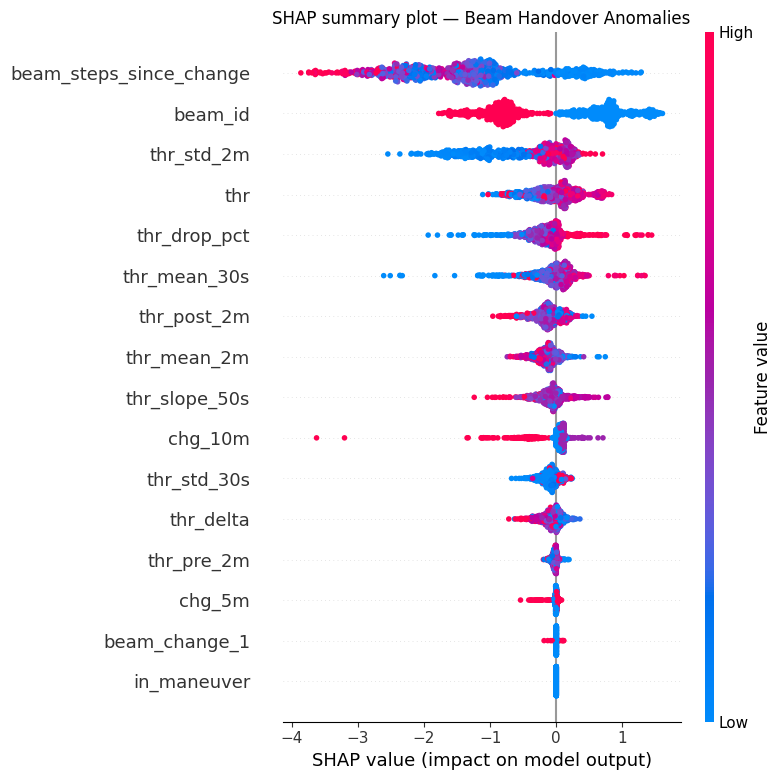


=== Beam handover anomaly candidate 1 ===
Time: 2021-11-25 04:31:30+00:00 | P(anomalous handover): 0.961


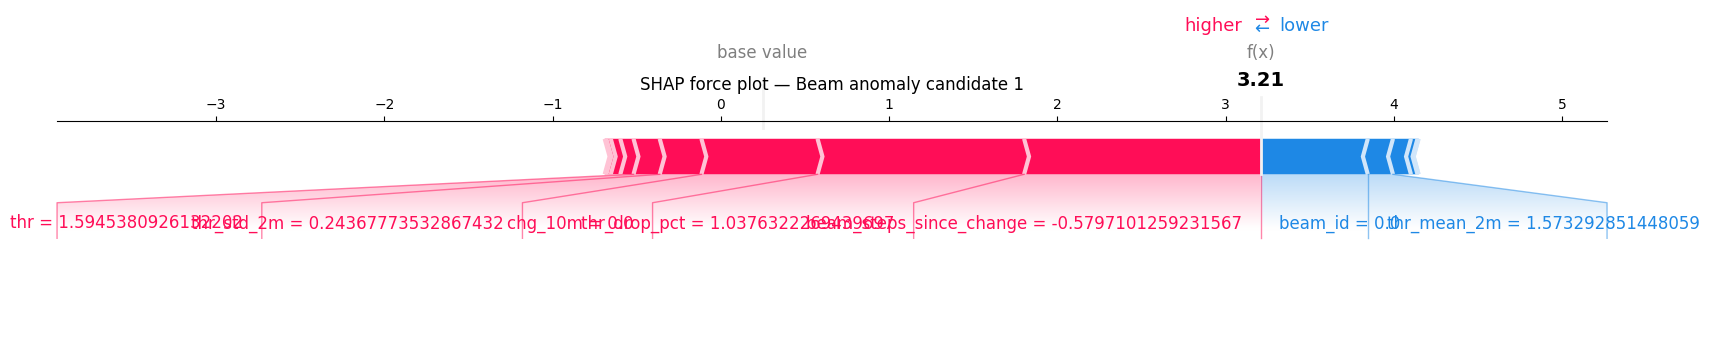


=== Beam handover anomaly candidate 2 ===
Time: 2021-11-27 16:24:10+00:00 | P(anomalous handover): 0.96


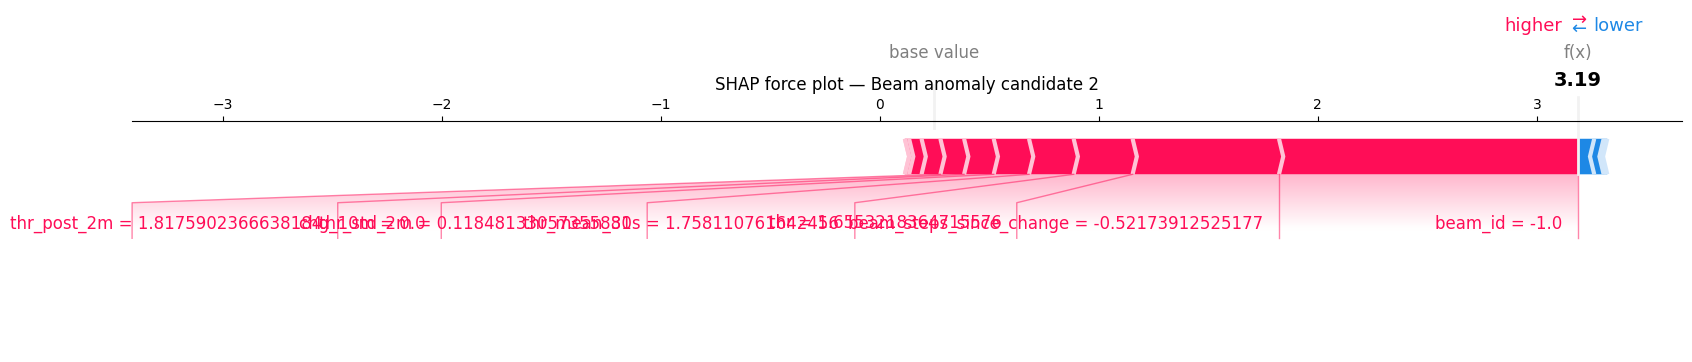


=== Beam handover anomaly candidate 3 ===
Time: 2021-11-27 12:48:50+00:00 | P(anomalous handover): 0.956


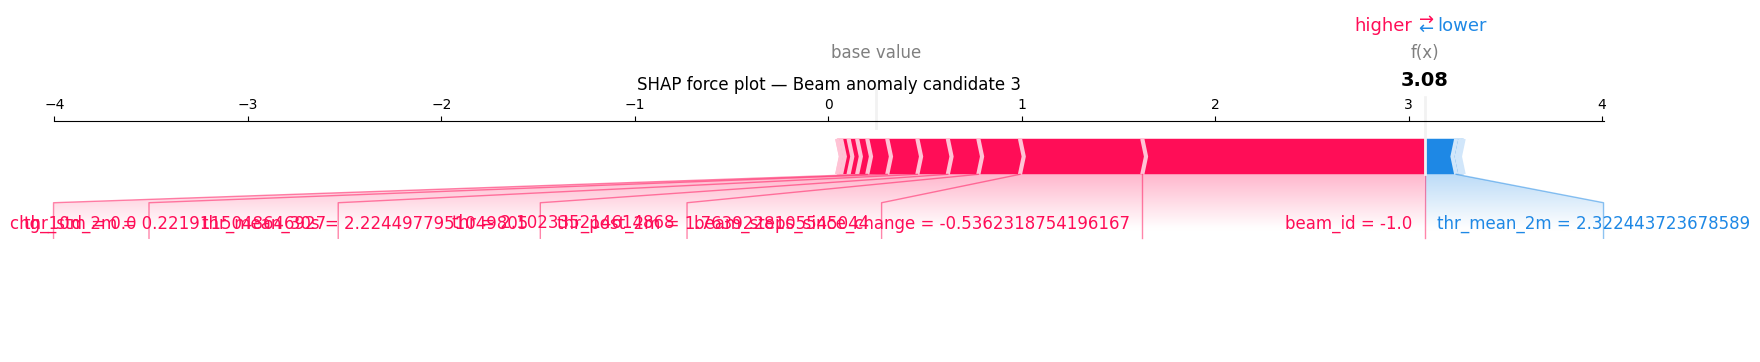


=== Beam handover anomaly candidate 4 ===
Time: 2021-11-28 12:24:20+00:00 | P(anomalous handover): 0.956


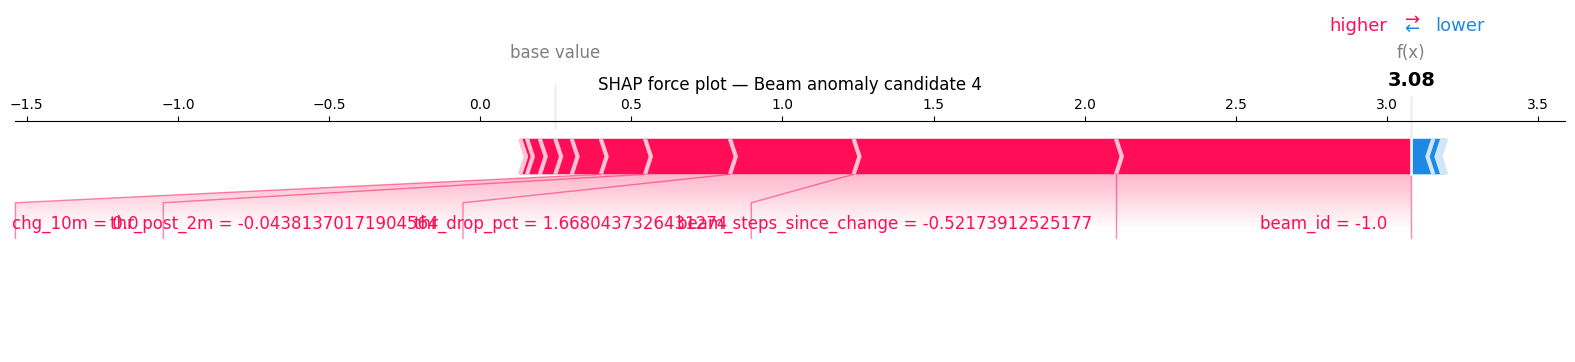


=== Beam handover anomaly candidate 5 ===
Time: 2021-11-29 08:48:00+00:00 | P(anomalous handover): 0.956


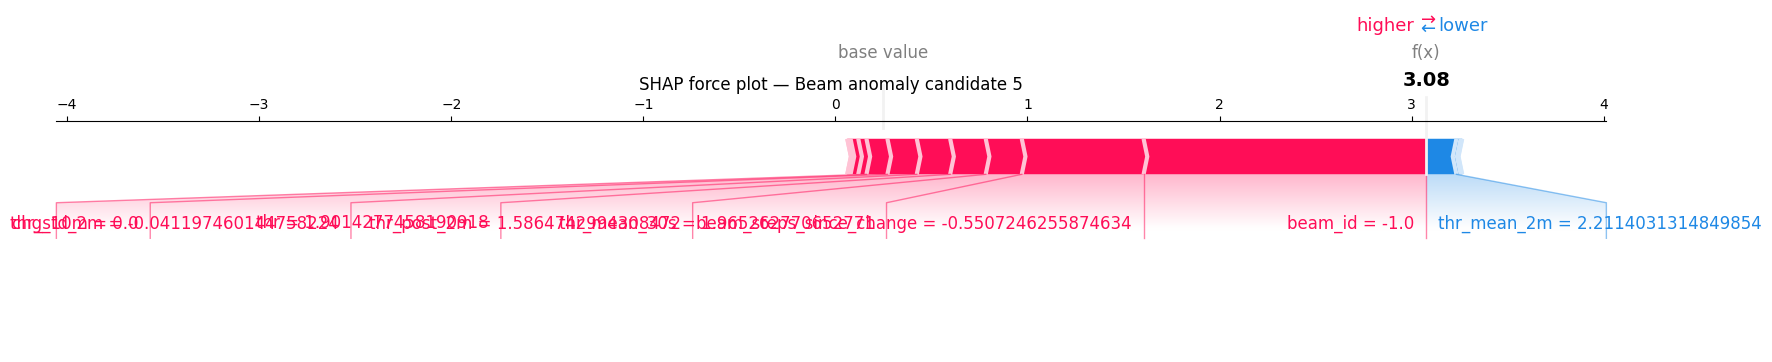

In [12]:
# Step 12 – XAI with SHAP for Beam Handover Anomalies
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Explain which features drive the model's predictions of anomalous handovers
#   - Provide both global (feature ranking) and local (per-event) explanations
# Inputs required:
#   - X_train, X_test, clf (from Step 8/9)
#   - proba_test, test_index, y_test (from Step 9)

!pip -q install shap
import shap

# 12.1 Prepare data for SHAP
X_train_shap = X_train.copy()
X_test_shap  = X_test.copy()
feature_names = X_train_shap.columns.tolist()

# 12.2 Create SHAP TreeExplainer for the XGB model
explainer = shap.TreeExplainer(clf)

# Use a sample of X_test for efficiency
n_sample = min(1000, len(X_test_shap))
sample_idx = np.random.RandomState(42).choice(len(X_test_shap), size=n_sample, replace=False)
X_sample = X_test_shap.iloc[sample_idx]

shap_values_sample = explainer.shap_values(X_sample)

# 12.3 Global explanation: which features matter most for anomalous handovers?
print("[Step12] Global SHAP summary for beam handover anomaly model:")
shap.summary_plot(
    shap_values_sample,
    X_sample,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP summary plot — Beam Handover Anomalies")
plt.tight_layout()
plt.show()

# 12.4 Local explanations: top high-probability anomalous handovers
proba_test_arr = np.asarray(proba_test)
test_index_arr = np.asarray(test_index)

# Focus on time steps where y_test == 1 (true anomalous) to get meaningful examples
candidate_mask = (y_test == 1)
candidate_indices = np.where(candidate_mask)[0]

if len(candidate_indices) > 0:
    # Rank by model probability among positives
    candidate_probs = proba_test_arr[candidate_indices]
    top_k = 5
    top_order = np.argsort(candidate_probs)[-top_k:][::-1]
    top_idx = candidate_indices[top_order]

    for rank, i in enumerate(top_idx, start=1):
        t = test_index_arr[i]
        p = proba_test_arr[i]
        print(f"\n=== Beam handover anomaly candidate {rank} ===")
        print("Time:", t, "| P(anomalous handover):", round(p, 3))

        x_instance = X_test_shap.iloc[[i]]
        shap_vals_instance = explainer.shap_values(x_instance)

        shap.force_plot(
            explainer.expected_value,
            shap_vals_instance[0],
            x_instance,
            matplotlib=True,
            show=False
        )
        plt.title(f"SHAP force plot — Beam anomaly candidate {rank}")
        plt.show()
else:
    print("[Step12] No positive anomalies in TEST set to explain.")




Beam handover SHAP event window: 2021-11-29 23:50:00+00:00 -> 2021-11-30 00:30:00+00:00
Saved handover event heatmap to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/handover_event_heatmap.png


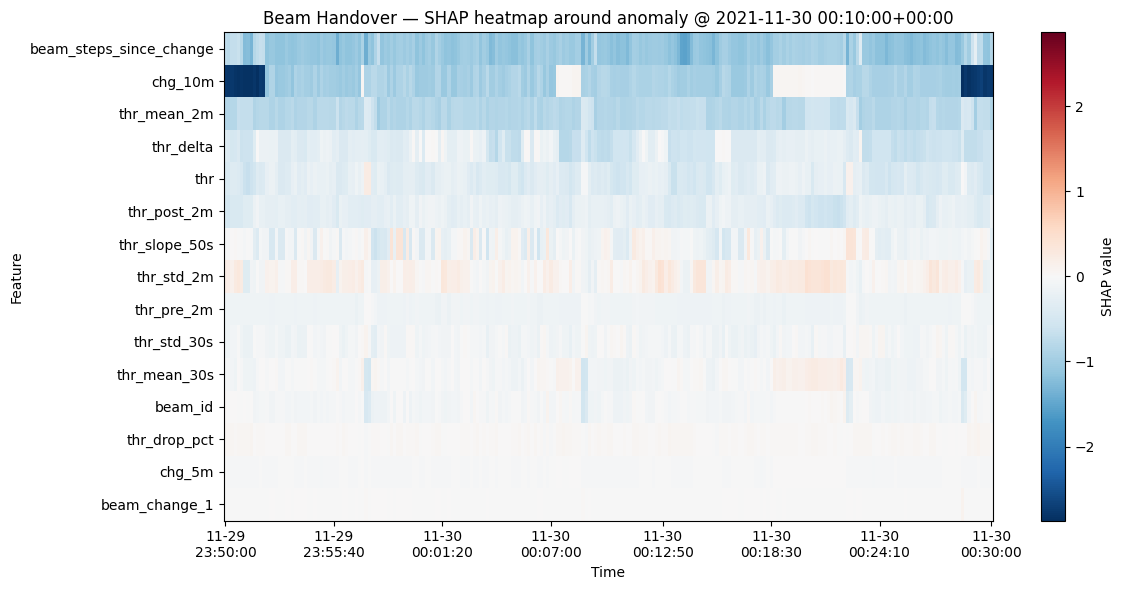

Saved handover continuous heatmap to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/handover_continuous_heatmap.png


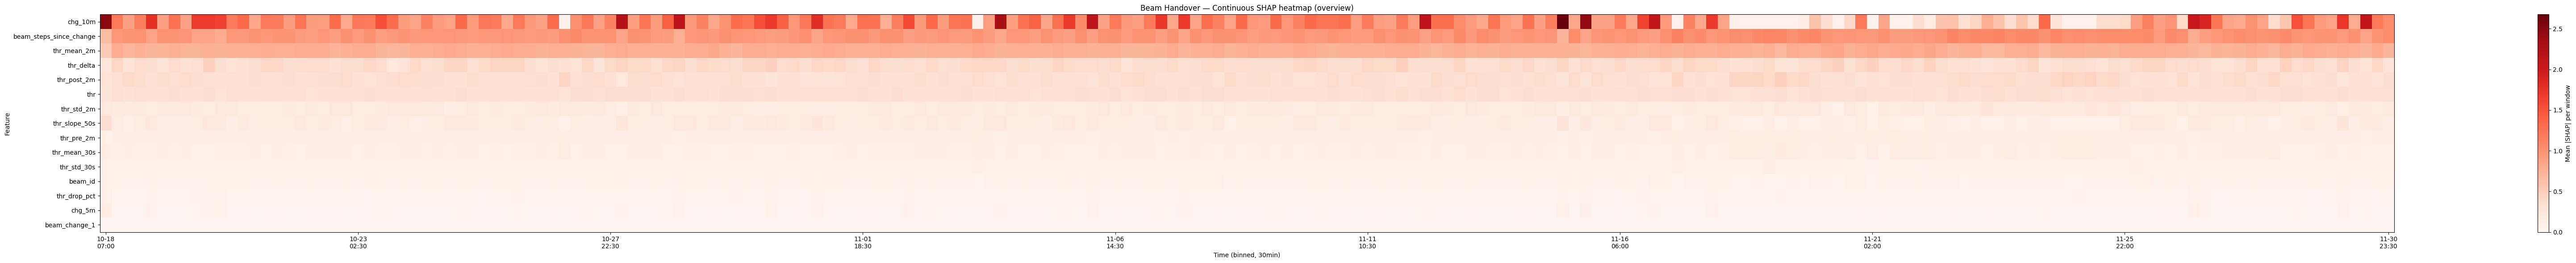

=== SHAP heatmaps for Beam Handover done. ===


In [13]:
# Step 12B – SHAP HEATMAPS
# -------------------------------------------------------------------------------------------------

# === BEAM HANDOVER — SHAP HEATMAPS (EVENT + CONTINUOUS) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = False

OUT_HO = os.path.join(DATA_DIR, "artifacts_handover")
os.makedirs(OUT_HO, exist_ok=True)

# X is the full feature matrix with DatetimeIndex (Step8),
# X_test and proba_test are from the early-warning model (Step9/10),
# explainer = shap.TreeExplainer(clf) was already created earlier.

# -------------------------------------------------------------------
# Helper 1: compute SHAP values for a given time window
# -------------------------------------------------------------------
def compute_shap_window_handover(explainer,
                                 X_full: pd.DataFrame,
                                 t_start: pd.Timestamp,
                                 t_end: pd.Timestamp,
                                 max_points: int = 300):
    """
    Compute SHAP values for a time window [t_start, t_end] on X_full.
    """
    X_win = X_full.loc[t_start:t_end]
    if X_win.empty:
        raise ValueError("No samples in the requested time window.")

    if len(X_win) > max_points:
        idx = np.linspace(0, len(X_win) - 1, max_points).astype(int)
        X_win = X_win.iloc[idx]

    shap_vals = explainer.shap_values(X_win)
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[0]

    return X_win, np.array(shap_vals)

# -------------------------------------------------------------------
# Helper 2: per-event SHAP heatmap
# -------------------------------------------------------------------
def plot_shap_event_heatmap_handover(X_win: pd.DataFrame,
                                     shap_vals: np.ndarray,
                                     top_n_features: int = 15,
                                     title: str = None,
                                     save_path: str = None):
    """
    SHAP 'saliency-style' heatmap over time for one handover anomaly window.
    """
    assert shap_vals.shape[0] == len(X_win)
    feature_names = X_win.columns

    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    order = np.argsort(mean_abs)[::-1]
    if top_n_features is not None:
        order = order[:top_n_features]

    shap_sel = shap_vals[:, order]
    feat_sel = feature_names[order]
    mat = shap_sel.T
    times = X_win.index

    plt.figure(figsize=(max(8, len(times) / 20), max(4, top_n_features * 0.4)))
    vmax = np.max(np.abs(mat))
    im = plt.imshow(
        mat,
        aspect="auto",
        cmap="RdBu_r",
        interpolation="nearest",
        vmin=-vmax,
        vmax=vmax,
    )
    plt.colorbar(im, label="SHAP value")

    plt.yticks(ticks=np.arange(len(feat_sel)), labels=feat_sel)

    n_ticks = min(8, len(times))
    tick_idx = np.linspace(0, len(times) - 1, n_ticks).astype(int)
    tick_labels = [times[i].strftime("%m-%d\n%H:%M:%S") for i in tick_idx]
    plt.xticks(ticks=tick_idx, labels=tick_labels)

    plt.xlabel("Time")
    plt.ylabel("Feature")
    plt.title(title or "Beam Handover — SHAP heatmap around anomalous handover")

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print("Saved handover event heatmap to:", save_path)
    plt.show()

# -------------------------------------------------------------------
# Helper 3: continuous SHAP heatmap (overview)
# -------------------------------------------------------------------
def plot_shap_continuous_heatmap_handover(explainer,
                                          X_full: pd.DataFrame,
                                          window_size: str = "30min",
                                          max_windows: int = 200,
                                          top_n_features: int = 15,
                                          title: str = None,
                                          save_path: str = None):
    """
    Continuous SHAP heatmap for Beam Handover model.
    Each column = time window, each row = feature, colour = mean |SHAP|.
    """
    X_grouped = []
    time_bins = []
    for t_bin, X_bin in X_full.groupby(pd.Grouper(freq=window_size)):
        if X_bin.empty:
            continue
        X_grouped.append(X_bin)
        time_bins.append(t_bin)

    if not X_grouped:
        raise ValueError("No data for handover SHAP continuous heatmap.")

    if len(X_grouped) > max_windows:
        idx = np.linspace(0, len(X_grouped) - 1, max_windows).astype(int)
        X_grouped = [X_grouped[i] for i in idx]
        time_bins = [time_bins[i] for i in idx]

    feature_names = X_full.columns
    mat_list = []

    for X_bin in X_grouped:
        X_bin_small = X_bin
        if len(X_bin_small) > 300:
            idx = np.linspace(0, len(X_bin_small) - 1, 300).astype(int)
            X_bin_small = X_bin_small.iloc[idx]

        shap_vals_bin = explainer.shap_values(X_bin_small)
        if isinstance(shap_vals_bin, list):
            shap_vals_bin = shap_vals_bin[0]

        mean_abs_bin = np.mean(np.abs(shap_vals_bin), axis=0)
        mat_list.append(mean_abs_bin)

    mat = np.vstack(mat_list).T  # (n_features, n_windows)

    global_mean_abs = np.mean(mat, axis=1)
    order = np.argsort(global_mean_abs)[::-1]
    if top_n_features is not None:
        order = order[:top_n_features]

    mat_sel = mat[order, :]
    feat_sel = feature_names[order]

    plt.figure(figsize=(max(8, len(time_bins) / 3), max(4, top_n_features * 0.4)))
    im = plt.imshow(
        mat_sel,
        aspect="auto",
        cmap="Reds",
        interpolation="nearest",
        vmin=0,
        vmax=np.max(mat_sel),
    )
    plt.colorbar(im, label="Mean |SHAP| per window")

    plt.yticks(ticks=np.arange(len(feat_sel)), labels=feat_sel)

    n_ticks = min(10, len(time_bins))
    tick_idx = np.linspace(0, len(time_bins) - 1, n_ticks).astype(int)
    tick_labels = [time_bins[i].strftime("%m-%d\n%H:%M") for i in tick_idx]
    plt.xticks(ticks=tick_idx, labels=tick_labels)

    plt.xlabel(f"Time (binned, {window_size})")
    plt.ylabel("Feature")
    plt.title(title or "Beam Handover — Continuous SHAP heatmap (overview)")

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print("Saved handover continuous heatmap to:", save_path)
    plt.show()

# -------------------------------------------------------------------
# PART A — pick an "anomalous handover" window
# -------------------------------------------------------------------
# Fallback: use highest predicted anomaly probability on TEST
proba_test_arr = np.asarray(proba_test)
X_test_index = np.asarray(X_test.index)
i_top = int(np.argmax(proba_test_arr))
event_center = pd.to_datetime(X_test_index[i_top])

pad = pd.Timedelta(minutes=20)
t_start = event_center - pad
t_end = event_center + pad
print("Beam handover SHAP event window:", t_start, "->", t_end)

X_win_ho, shap_vals_ho = compute_shap_window_handover(
    explainer=explainer,
    X_full=X,
    t_start=t_start,
    t_end=t_end,
    max_points=300,
)

plot_shap_event_heatmap_handover(
    X_win_ho,
    shap_vals_ho,
    top_n_features=15,
    title=f"Beam Handover — SHAP heatmap around anomaly @ {event_center}",
    save_path=os.path.join(OUT_HO, "handover_event_heatmap.png"),
)

# -------------------------------------------------------------------
# PART B — continuous overview
# -------------------------------------------------------------------
plot_shap_continuous_heatmap_handover(
    explainer=explainer,
    X_full=X,
    window_size="30min",
    max_windows=200,
    top_n_features=15,
    title="Beam Handover — Continuous SHAP heatmap (overview)",
    save_path=os.path.join(OUT_HO, "handover_continuous_heatmap.png"),
)

print("=== SHAP heatmaps for Beam Handover done. ===")


In [14]:
# Step 13 - LOCK WINNER CONFIG + SAVE MODEL/THRESHOLDS/SCORES
# -------------------------------------------------------------------------------------------------
# Note: Prefer the adaptive lock from step 11C; else fall back to micro-winner
lock_path = os.path.join(ART_DIR, "eventization_winner.json")
if os.path.exists(lock_path):
    with open(lock_path, "r") as f:
        W = json.load(f)
    print("[Step13] Using existing lock:", W["name"])
else:
    # fallback to micro-preset 'winner' from Step 11 block
    W = {
        "name": winner["Preset"],
        "ema_span": 4,
        "on_thr": float(winner["ON"]),
        "off_thr": float(winner["OFF"]),
        "k": int(winner["K/M"].split("/")[0]),
        "m": int(winner["K/M"].split("/")[1]),
        "min_dur_s": int(winner["min_dur_s"]),
        "refractory_s": int(winner["refractory_s"]),
        "far_per_hr": float(winner["FAR/hr"]),
        "delay_s": float(winner["Delay_s"]) if winner["Delay_s"] is not None else None,
        "precision": float(winner["Precision"]) if winner["Precision"] is not None else None,
        "recall": float(winner["Recall"]) if winner["Recall"] is not None else None,
        "alerts": int(winner["Alerts"])
    }
    with open(lock_path, "w") as f:
        json.dump(W, f, indent=2)
    print("[Step13] Created lock from micro-preset:", W["name"])

# Thresholding context (validation)
thr_cfg = {
    "target_precision": float(TARGET_PRECISION),
    "tau_val": float(thr_star),
    "validation_ap": float(ap_va),
    "early_warning_min": int(EARLY_WARNING_MIN)
}
with open(os.path.join(ART_DIR, "thresholding.json"), "w") as f:
    json.dump(thr_cfg, f, indent=2)

# Save test scores — use X_test / y_test to avoid NameError
pd.DataFrame({
    "timestamp": X_test.index,
    "proba": proba_test,
    "y_true": y_test.reindex(X_test.index).values
}).to_csv(os.path.join(ART_DIR, "test_scores.csv"), index=False)

# Save model
clf.save_model(os.path.join(ART_DIR, "model_handover.json"))
print("Saved:", os.path.join(ART_DIR, "thresholding.json"))
print("Saved:", os.path.join(ART_DIR, "test_scores.csv"))
print("Saved:", os.path.join(ART_DIR, "model_handover.json"))


[Step13] Using existing lock: SLA-ADAPT-GUARDRAIL
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/thresholding.json
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/test_scores.csv
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/model_handover.json


In [15]:
# Step 14 - INSPECT HANDOVER TABLE AND RULE CONTRIBUTIONS
# -------------------------------------------------------------------------------------------------
HOV_inspect = HOV.copy()
if not HOV_inspect.empty:
    HOV_inspect["rules_hit"] = (HOV_inspect[["r1_drop","r2_ping","r3_slow"]].sum(axis=1))
HOV_inspect.tail(10)


,pre,post,drop_pct,since_prev_s,recovery_s,r1_drop,r2_ping,r3_slow,anomalous,rules_hit
t,,,,,,,,,,
2021-11-30 22:05:20+00:00,220.845150,221.425733,-0.002629,410.0,0.0,0,0,0,0,0
2021-11-30 22:06:40+00:00,220.971417,221.332783,-0.001635,80.0,0.0,0,0,0,0,0
2021-11-30 22:27:30+00:00,243.274183,236.277478,0.028761,1250.0,0.0,0,0,0,0,0
2021-11-30 22:46:30+00:00,226.442333,239.621128,-0.058199,1140.0,0.0,0,0,0,0,0
2021-11-30 22:52:30+00:00,218.005292,223.210083,-0.023875,360.0,0.0,0,0,0,0,0
2021-11-30 23:10:20+00:00,223.127075,234.689611,-0.051820,1070.0,0.0,0,0,0,0,0
2021-11-30 23:14:20+00:00,232.432350,228.937222,0.015037,240.0,0.0,0,0,0,0,0
2021-11-30 23:34:30+00:00,220.738667,236.326372,-0.070616,1210.0,0.0,0,0,0,0,0
2021-11-30 23:39:40+00:00,223.659025,222.108139,0.006934,310.0,0.0,0,0,0,0,0


In [16]:
# Step 15 - CONCLUSION SUMMARY — Beam Handover Anomalies (final export)
# ---------------------------------------------------------------
# Requires helpers from Step 11 to be already defined in this notebook scope:
#   hysteresis, n_of_m, series_to_events, prune_and_merge,
#   alerts_per_hour, detection_delays_median, event_overlap_precision_recall

from datetime import datetime, timezone
import os, json, numpy as np, pandas as pd

# ---------- small utils ----------
def _fmt(x, nd=3):
    import numbers, numpy as _np
    if x is None: return "NA"
    if isinstance(x, numbers.Real):
        if _np.isnan(x) or _np.isinf(x): return "NA"
        return f"{x:.{nd}f}" if not float(x).is_integer() else str(int(x))
    return str(x)

def _align_gt(y_like_index):
    """Return GT events (merged) aligned to the test_index timeline."""
    y_aligned = (
        pd.Series(y_test, index=getattr(y_test, 'index', y_like_index))
          .reindex(y_like_index).replace([np.inf, -np.inf], 0).fillna(0).clip(0,1).astype(int)
    )
    return prune_and_merge(series_to_events(y_aligned), 1, 0)

def _events_from_cfg(cfg, proba_series, idx):
    """Build predicted events + metrics from a config on the TEST window."""
    ema = int(cfg.get("ema_span", 4))
    on  = float(cfg.get("on_thr", 0.9))
    off = float(cfg.get("off_thr", 0.8))
    k   = int(cfg.get("k", 3))
    m   = int(cfg.get("m", 5))
    md  = int(cfg.get("min_dur_s", 90))
    ref = int(cfg.get("refractory_s", 240))

    prob_sm = pd.Series(proba_series, index=idx).ewm(span=ema, adjust=False).mean()
    hyst    = hysteresis(prob_sm, on, off)
    deb     = n_of_m((prob_sm >= on).astype(int), k, m)
    stable  = (hyst & deb).astype(int)
    pred    = prune_and_merge(series_to_events(stable), md, ref)

    tsec = (idx[-1] - idx[0]).total_seconds()
    far  = alerts_per_hour(pred, tsec)
    gt   = _align_gt(idx)
    delay = detection_delays_median(gt, pred)
    P, R  = event_overlap_precision_recall(gt, pred, 0.10)
    return pred, far, delay, P, R

# ---------- load final lock ----------
lock_path = os.path.join(ART_DIR, "eventization_winner.json")
with open(lock_path, "r") as f:
    W = json.load(f)

# ---------- recompute FINAL events/metrics on TEST ----------
pred_events, far_per_hr, delay_s, P_evt, R_evt = _events_from_cfg(W, proba_test, test_index)

# median lead time (optional, descriptive)
def _lead_time_median(true_events, pred_events):
    tstarts = [s for s,_ in true_events]
    pstarts = [s for s,_ in pred_events]
    if not tstarts or not pstarts: return np.nan
    leads, j = [], 0
    for ts in tstarts:
        while j < len(pstarts) and pstarts[j] <= ts: j += 1
        before = pstarts[j-1] if j>0 else None
        after  = pstarts[j]   if j<len(pstarts) else None
        if before is not None: leads.append((ts - before).total_seconds())
        elif after is not None: leads.append((ts - after).total_seconds())
    return float(np.median(leads)) if leads else np.nan

gt_events = _align_gt(test_index)
lead_s    = _lead_time_median(gt_events, pred_events)

# ---------- persist config.json ----------
cfg = {
    "problem": "Beam Handover Anomalies (inferred beam_id from MODEM OUT clustering)",
    "resample": "10s",
    "beam_inference": {
        "pca_dim": int(BEAM_PCA_DIM),
        "kmeans_k": int(BEAM_K),
        "flicker_smoothing_s": 60
    },
    "handover_rules": {
        "drop_pct_thr": float(THR["drop_pct_thr"]),
        "pingpong_s":   float(THR["pingpong_s"]),
        "recovery_s_thr": float(THR["recovery_s_thr"])
    },
    "thresholding": {
        "target_precision": float(TARGET_PRECISION),
        "tau_val": float(thr_star),
        "validation_ap": float(ap_va),
        "early_warning_min": int(EARLY_WARNING_MIN)
    },
    "eventization": {
        "ema_span": int(W.get("ema_span",4)),
        "on_thr": float(W["on_thr"]), "off_thr": float(W["off_thr"]),
        "k": int(W["k"]), "m": int(W["m"]),
        "min_dur_s": int(W["min_dur_s"]), "refractory_s": int(W["refractory_s"])
    },
    "metrics_test": {
        "far_per_hr": float(round(far_per_hr, 3)),
        "median_delay_s": (None if pd.isna(delay_s) else float(round(delay_s, 1))),
        "median_lead_s": (None if pd.isna(lead_s) else float(round(lead_s, 1))),
        "event_precision": (None if pd.isna(P_evt) else float(round(P_evt, 3))),
        "event_recall": (None if pd.isna(R_evt) else float(round(R_evt, 3))),
        "pred_events": int(len(pred_events)),
        "gt_events": int(len(gt_events))
    }
}
with open(os.path.join(ART_DIR, "config.json"), "w") as f:
    json.dump(cfg, f, indent=2)
print("Saved:", os.path.join(ART_DIR, "config.json"))

# ---------- build summary.md ----------
summary_md = f"""
# Beam Handover Anomalies — Final Summary
**Run date (UTC):** {datetime.now(timezone.utc).isoformat(timespec='seconds')}

**Beam inference**
- MODEM *_OUT* normalized vector -> PCA({BEAM_PCA_DIM}) -> KMeans(K={BEAM_K})
- Handover = beam_id change (smoothed ≥60s)

**Anomaly rules (trained on TRAIN)**
- Post-handover throughput drop > {THR['drop_pct_thr']:.3f}
- Ping-pong within {THR['pingpong_s']:.0f}s
- Recovery time > {THR['recovery_s_thr']:.0f}s

**Model (early warning)**
- XGB on rolling throughput + beam dynamics; target=anomalous handover in {int(EARLY_WARNING_MIN)} min

**Validation**
- AP: {ap_va:.3f} | τ (val): {thr_star:.3f}

**Eventization preset (final)**
- EMA span: {W.get('ema_span',4)}
- ON/OFF: {W['on_thr']:.3f} / {W['off_thr']:.3f}
- Debounce K/M: {W['k']}/{W['m']}
- Min duration / Refractory: {W['min_dur_s']}s / {W['refractory_s']}s

**Test metrics (this window)**
- FAR: {far_per_hr:.3f} alerts/hour
- Median detection delay: {('NA' if pd.isna(delay_s) else f'{delay_s:.1f}')} s
- Median lead time: {('NA' if pd.isna(lead_s) else f'{lead_s:.1f}')} s
- Event Precision / Recall: {('NA' if pd.isna(P_evt) else f'{P_evt:.3f}')} / {('NA' if pd.isna(R_evt) else f'{R_evt:.3f}')}
- Pred events / GT events: {len(pred_events)} / {len(gt_events)}

**Notes**
- All thresholds learned on TRAIN only; timelines split 60/20/20.
""".strip()

# ---------- optional: research-only "best-by-rank" section ----------
best_rank_path = os.path.join(ART_DIR, "eventization_best_by_rank.json")
if os.path.exists(best_rank_path):
    with open(best_rank_path, "r") as f:
        B = json.load(f)
    pred_b, far_b, delay_b, P_b, R_b = _events_from_cfg(B, proba_test, test_index)
    alerts_b = len(pred_b)

    if alerts_b >= 1:
        summary_md += (
            "\n\n**Eventization (best-by-rank, research-only)**\n"
            f"- EMA: {B.get('ema_span','NA')}, "
            f"ON/OFF: {_fmt(B.get('on_thr'))} / {_fmt(B.get('off_thr'))}, "
            f"K/M: {B.get('k','NA')}/{B.get('m','NA')}, "
            f"min/refr: {B.get('min_dur_s','NA')}s / {B.get('refractory_s','NA')}s\n"
            f"- FAR: {_fmt(far_b)} alerts/hour, "
            f"Precision/Recall: {_fmt(P_b)} / {_fmt(R_b)}, "
            f"Delay: {_fmt(delay_b,1)} s, Alerts: {alerts_b}\n"
        )
        print(
            "\n[Step15][Best-by-rank] "
            f"EMA={B.get('ema_span')} ON/OFF={_fmt(B.get('on_thr'))}/{_fmt(B.get('off_thr'))} "
            f"K/M={B.get('k')}/{B.get('m')} min/refr={B.get('min_dur_s')}s/{B.get('refractory_s')}s | "
            f"FAR={_fmt(far_b)}/hr P/R={_fmt(P_b)}/{_fmt(R_b)} Delay={_fmt(delay_b,1)}s Alerts={alerts_b}"
        )
    else:
        print("[Step15] best-by-rank recomputed alerts = 0 — not appending to summary.")
else:
    print("[Step15] best-by-rank file not found; skipping research-only section.")

# ---------- save summary ----------
with open(os.path.join(ART_DIR, "summary.md"), "w") as f:
    f.write(summary_md + "\n")
print("Saved:", os.path.join(ART_DIR, "summary.md"))

# ---------- console echo (short) ----------
print("\n--- HANDOVER CONCLUSION ---\n")
print(summary_md)


Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/config.json
[Step15] best-by-rank recomputed alerts = 0 — not appending to summary.
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/summary.md

--- HANDOVER CONCLUSION ---

# Beam Handover Anomalies — Final Summary
**Run date (UTC):** 2025-11-25T21:03:21+00:00

**Beam inference**
- MODEM *_OUT* normalized vector -> PCA(6) -> KMeans(K=2)
- Handover = beam_id change (smoothed ≥60s)

**Anomaly rules (trained on TRAIN)**
- Post-handover throughput drop > 0.042
- Ping-pong within 300s
- Recovery time > 45s

**Model (early warning)**
- XGB on rolling throughput + beam dynamics; target=anomalous handover in 2 min

**Validation**
- AP: 0.105 | τ (val): 0.946

**Eventization preset (final)**
- EMA span: 4
- ON/OFF: 0.796 / 0.676
- Debounce K/M: 3/5
- Min duration / Refractory: 120s / 60s

**Test metrics (this window)**
- FAR: 0.010 alerts/hour
- Median detection delay: 846